# Home Credit Default Risk - Modeling Part

## 1. Introduction to Modeling Part

**Context**

    In the previous notebook (EDA train_test), we performed a comprehensive EDA, handled missing values, detected anomalies, and created engineered features for the Home Credit dataset.
    
    This notebook focuses on building, evaluating, and tuning predictive models for loan default risk.
    
    The goal is to create a proof-of-concept predictive pipeline that can later be used to demonstrate business impact to stakeholders.


**Goals:**

    - Build multiple predictive models to identify applicants at risk of default.  
    
    - Compare baseline and advanced models to select top-performing algorithms.  
    
    - Evaluate model performance using cross-validation and relevant metrics (AUC, PR-AUC).  
    
    - Perform hyperparameter optimization to improve predictive power and robustness.

**Objectives:**

    1. Preprocess the main training dataset using a consistent `preprocess_features` function. 
    
    2. Train and evaluate six candidate models: Logistic Regression, Random Forest, CatBoost, LightGBM, XGBoost, and HistGradientBoosting.  
    
    3. Identify the best-performing models for further experimentation (LightGBM and XGBoost). 
    
    4. Merge additional datasets (bureau, bureau balance, previous loans, payments, credic card balance, installments) to enhance predictive performance.  
    
    5. Re-evaluate top models using 5-fold cross-validation. 
    
    6. Perform hyperparameter tuning using Optuna for final model selection.
    

## 2. Data loading

In [1]:
%load_ext jupyter_black

In [50]:
import sys
import os
import time
import json
import warnings
from functools import partial
from typing import Dict, Optional, List, Tuple, Union

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import shap
from optuna.samplers import TPESampler

from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (
    StratifiedKFold,
    train_test_split,
    cross_val_score,
    cross_val_predict,
    KFold,
)
from sklearn.ensemble import (
    VotingClassifier,
    StackingClassifier,
    RandomForestClassifier,
    HistGradientBoostingClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    f1_score,
    average_precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    roc_curve,
    auc,
    precision_recall_curve,
    precision_score,
    recall_score,
)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    RobustScaler,
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder,
    FunctionTransformer,
)

from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool

import category_encoders as ce
from category_encoders import TargetEncoder

from pandas.api.types import is_numeric_dtype

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", message="X does not have valid feature names")

In [12]:
from Data.utils_EDA import feature_types, missing_columns, calculate_missing_rows
from Data.utils_modeling import (
    downcast_numeric_col,
    handle_date_anom_1000,
    handle_date_anom_50,
    convert_days_to_years,
    feature_engineering,
    preprocess_features,
    engineer_features_from_table_enhanced,
    create_installment_custom_features,
    create_bureau_custom_features,
    create_cc_balance_custom_features,
    create_pos_cash_custom_features,
    create_prev_app_custom_features_balanced,
    create_bureau_balance_custom_features,
    engineer_features_from_table,
)
from Data.utils_vizualization import (
    plot_roc_pr_curves,
    plot_calibration_curves,
    analyze_shap_separate_plots,
    plot_shap_top20_comparison,
    plot_threshold_optimization,
)

**Main datasets**

In [4]:
df_train = pd.read_csv(r"../Data/application_train.csv")
df_train.shape

(307511, 122)

In [5]:
df_test = pd.read_csv(r"../Data/application_test.csv")
df_test.shape

(48744, 121)

**Additional datasets**

In [6]:
bureau = pd.read_csv(r"../Data/bureau.csv")
bureau.shape

(1716428, 17)

In [7]:
bureau_balance = pd.read_csv(r"../Data/bureau_balance.csv")
bureau_balance.shape

(27299925, 3)

In [8]:
credit_card_balance = pd.read_csv(r"../Data/credit_card_balance.csv")
credit_card_balance.shape

(3840312, 23)

In [9]:
prev = pd.read_csv(r"../Data/previous_application.csv")
prev.shape

(1670214, 37)

In [10]:
pos = pd.read_csv(r"../Data/POS_CASH_balance.csv")
pos.shape

(10001358, 8)

In [11]:
installments = pd.read_csv(r"../Data/installments_payments.csv")
installments.shape

(13605401, 8)

**Downcasting numeric columns**

In [13]:
downcast_numeric_col(installments)
downcast_numeric_col(bureau)
downcast_numeric_col(credit_card_balance)
downcast_numeric_col(prev)
downcast_numeric_col(pos)
pos.dtypes.unique()

array([dtype('int32'), dtype('int8'), dtype('float32'), dtype('O'),
       dtype('int16')], dtype=object)

## 3. Best model selection

In this section, we will evaluate the performance of six different models:
    
    CatBoost, 
    A gradient boosting library designed to handle categorical features directly and reduce overfitting. Often requires less feature preprocessing.
    
    LightGBM,
    A gradient boosting framework optimized for speed and memory efficiency, using leaf-wise tree growth. Handles large datasets with categorical variables effectively.
        
    XGBoost, 
    An efficient gradient boosting framework that uses advanced regularization and optimized tree-building. Known for strong performance on tabular data.
        
    HistGradientBoosting,
    A tree-based boosting algorithm from scikit-learn that uses histogram binning for efficiency. Handles large datasets well and is often competitive with gradient boosting libraries.
    
    Logistic Regression,
    A simple, interpretable linear model that estimates the probability of default using a logistic function. Serves as a baseline.
    
    Random Forest
    An ensemble of decision trees built on bootstrapped samples with feature randomness. Reduces overfitting and captures non-linear patterns.

Each model will be trained on the main preprocessed dataset. The top two models will be chosen by comparing their performance across key evaluation metrics: 
    
    ROC-AUC (Area Under the Receiver Operating Characteristic Curve) / main metric for Kaggle competition
    
    F1-Score, PR-AUC (Area Under the Precision-Recall Curve), 
    
    and training time.

**Feature preprocessing:**

    1. Numeric downcasting
    
    2. Date anomalies handling
    
    3. Convert DAYS to YEARS
    
    4. Rare category handling
    
    5. Missing value flags
    
    6. Building/collapsing flags
    
    7. Anomaly corrections
    
    8. Predictive feature engineering

In [14]:
train = df_train.copy()
train = preprocess_features(train)
train.shape

(307511, 144)

In [15]:
test = df_test.copy()
test = preprocess_features(test)
test.shape

(48744, 143)

**Splitting train dataset**

Disbalances dataset - stratify = y

In [17]:
X = train.drop(columns=["TARGET", "SK_ID_CURR"], errors="ignore")
y = train["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train: {X_train.shape[0]} samples, Test: {X_test.shape[0]} samples")

Train: 246008 samples, Test: 61503 samples


In [18]:
X.shape

(307511, 142)

**Defining preprocesor**

For tree base models (no scaling)

In [19]:
numeric = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

cat_pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        (
            "ordinal",
            OrdinalEncoder(
                handle_unknown="use_encoded_value",
                unknown_value=-1,
                encoded_missing_value=-2,
            ),
        ),
    ]
)


num_pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
    ]
)

preprocessor = ColumnTransformer(
    [("num", num_pipe, numeric), ("cat", cat_pipe, categorical)]
)

### A. LightGBM model

In [37]:
scale_pos_weight = (y == 0).sum() / (y == 1).sum()

model_lgbm = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "classifier",
            LGBMClassifier(
                random_state=42,
                n_estimators=500,
                verbose=-1,
                learning_rate=0.05,
                max_depth=5,
                subsample=0.8,
                min_child_samples=100,
                scale_pos_weight=scale_pos_weight,
            ),
        ),
    ]
)

In [38]:
start_time = time.time()
y_probs = cross_val_predict(model_lgbm, X_train, y_train, cv=5, method="predict_proba")[
    :, 1
]

y_pred = (y_probs >= 0.5).astype(int)
elapsed_time_lgbm = time.time() - start_time

print(classification_report(y_train, y_pred))

roc_auc_lgbm = roc_auc_score(y_train, y_probs)
f1_lgbm = f1_score(y_train, y_pred)
pr_auc_lgbm = average_precision_score(y_train, y_probs)
print(f"Mean ROC AUC: {roc_auc_lgbm:.4f}")
print(f"F1 Score: {f1_lgbm:.4f}")
print(f"PR-AUC: {pr_auc_lgbm:.4f}")
print(f"\nTotal time taken: {elapsed_time_lgbm:.2f} seconds")

              precision    recall  f1-score   support

           0       0.96      0.73      0.83    226148
           1       0.18      0.65      0.28     19860

    accuracy                           0.73    246008
   macro avg       0.57      0.69      0.56    246008
weighted avg       0.90      0.73      0.79    246008

Mean ROC AUC: 0.7629
F1 Score: 0.2786
PR-AUC: 0.2473

Total time taken: 163.92 seconds


The baseline LightGBM model achieves a ROC-AUC of 0.763, with an F1 score of 0.279 and PR-AUC of 0.247. 

While overall accuracy is high (0.73), this is largely due to the strong class imbalance: the model performs much better at predicting the majority class (precision 0.96, recall 0.73) than the minority class (precision 0.18, recall 0.65).

### B. Logistic regression - model

Linear model. We will use log scale and StandardScaler for numeric features and for low cardinality categorical features OneHotEncoder, for others TargetEncoder.

In [45]:
def safe_log(x):
    """Apply log1p only to finite positive values, else return 0."""
    x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
    out = np.zeros_like(x)
    mask = x > 0
    out[mask] = np.log1p(x[mask])
    return out


low_card_thresh = 10
low_card_cat = [col for col in categorical if X_train[col].nunique() <= low_card_thresh]
high_card_cat = [col for col in categorical if X_train[col].nunique() > low_card_thresh]

num_pipe_lr = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
        ("log_scale", FunctionTransformer(safe_log)),
        ("scaler", StandardScaler()),
    ]
)

low_card_pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]
)

high_card_pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        (
            "target_enc",
            ce.TargetEncoder(),
        ),
    ]
)

preprocessor_lr = ColumnTransformer(
    [
        ("num", num_pipe_lr, numeric),
        ("low_cat", low_card_pipe, low_card_cat),
        ("high_cat", high_card_pipe, high_card_cat),
    ]
)

model_lr = Pipeline(
    [
        ("preprocessor", preprocessor_lr),
        (
            "classifier",
            LogisticRegression(
                random_state=42,
                class_weight="balanced",
                penalty="l1",
                solver="liblinear",
                max_iter=1000,
                C=0.1,
            ),
        ),
    ]
)

In [46]:
start_time = time.time()

y_probs = cross_val_predict(model_lr, X_train, y_train, cv=5, method="predict_proba")[
    :, 1
]

y_pred = (y_probs >= 0.5).astype(int)

elapsed_time_lr = time.time() - start_time

print(classification_report(y_train, y_pred))

roc_auc_lr = roc_auc_score(y_train, y_probs)
f1_lr = f1_score(y_train, y_pred)
pr_auc_lr = average_precision_score(y_train, y_probs)
print(f"Mean ROC AUC: {roc_auc_lr:.4f}")
print(f"F1 Score: {f1_lr:.4f}")
print(f"PR-AUC: {pr_auc_lr:.4f}")
print(f"\nTotal time taken: {elapsed_time_lr:.2f} seconds")

              precision    recall  f1-score   support

           0       0.96      0.70      0.81    226148
           1       0.16      0.68      0.26     19860

    accuracy                           0.69    246008
   macro avg       0.56      0.69      0.54    246008
weighted avg       0.90      0.69      0.76    246008

Mean ROC AUC: 0.7519
F1 Score: 0.2635
PR-AUC: 0.2317

Total time taken: 2750.32 seconds


The logistic regression baseline achieves a ROC-AUC of 0.752, with an F1 score of 0.264 and PR-AUC of 0.232. 

Similar to LightGBM, accuracy is dominated by the majority class (0.96 precision, 0.70 recall), while minority class detection remains weak (0.16 precision, 0.68 recall). Overall, it performs slightly worse than LightGBM across most metrics, but could serve as a useful linear baseline for comparison.

### C. CatBoost

In [50]:
categorical_indices = [X_train.columns.get_loc(col) for col in categorical]

model_cat = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        (
            "classifier",
            CatBoostClassifier(
                random_state=42,
                verbose=0,
                auto_class_weights="Balanced",
                cat_features=categorical_indices,
                iterations=500,
                learning_rate=0.05,
                depth=6,
            ),
        ),
    ]
)

In [51]:
X_train_cb = X_train.copy()
X_train_cb[categorical] = X_train_cb[categorical].astype(str).fillna("MISSING")

cat_indices = [X_train_cb.columns.get_loc(col) for col in categorical]

kf = KFold(n_splits=5, shuffle=True, random_state=42)
y_probs = np.zeros(len(X_train_cb))

start_time = time.time()

for train_idx, test_idx in kf.split(X_train_cb):
    X_tr, X_te = X_train_cb.iloc[train_idx], X_train_cb.iloc[test_idx]
    y_tr = y_train.iloc[train_idx]

    train_pool = Pool(X_tr, y_tr, cat_features=cat_indices)
    model = CatBoostClassifier(
        iterations=500,
        learning_rate=0.05,
        depth=6,
        random_state=42,
        verbose=0,
        auto_class_weights="Balanced",
    )
    model.fit(train_pool)

    y_probs[test_idx] = model.predict_proba(X_te)[:, 1]

y_pred = (y_probs >= 0.5).astype(int)

roc_auc_cb = roc_auc_score(y_train, y_probs)
f1_cb = f1_score(y_train, y_pred)
pr_auc_cb = average_precision_score(y_train, y_probs)

elapsed_time_cb = time.time() - start_time

print(classification_report(y_train, y_pred))

print(f"Mean ROC AUC: {roc_auc_cb:.4f}")
print(f"F1 Score: {f1_cb:.4f}")
print(f"PR-AUC: {pr_auc_cb:.4f}")
print(f"\nTotal time taken: {elapsed_time_cb:.2f} seconds")

              precision    recall  f1-score   support

           0       0.96      0.72      0.82    226148
           1       0.17      0.68      0.28     19860

    accuracy                           0.71    246008
   macro avg       0.57      0.70      0.55    246008
weighted avg       0.90      0.71      0.78    246008

Mean ROC AUC: 0.7644
F1 Score: 0.2757
PR-AUC: 0.2462

Total time taken: 1400.20 seconds


CatBoost achieves a ROC-AUC of 0.764, an F1 score of 0.276, and a PR-AUC of 0.246, putting it slightly ahead of LightGBM and logistic regression.

While accuracy remains high due to the majority class, CatBoost demonstrates stronger minority class recall (0.68), making it a more balanced option among the single models tested.

### D. Random forest

In [52]:
model_rf = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "classifier",
            RandomForestClassifier(
                random_state=42,
                n_estimators=200,
                max_depth=10,
                class_weight="balanced_subsample",
                n_jobs=-1,
            ),
        ),
    ]
)

In [53]:
start_time = time.time()

y_probs = cross_val_predict(model_rf, X_train, y_train, cv=5, method="predict_proba")[
    :, 1
]

y_pred = (y_probs >= 0.5).astype(int)

elapsed_time_rf = time.time() - start_time

roc_auc_rf = roc_auc_score(y_train, y_probs)
f1_rf = f1_score(y_train, y_pred)
pr_auc_rf = average_precision_score(y_train, y_probs)

print(classification_report(y_train, y_pred))
print(f"Mean ROC AUC: {roc_auc_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")
print(f"PR-AUC: {pr_auc_rf:.4f}")
print(f"\nTotal time taken: {elapsed_time_rf:.2f} seconds")

              precision    recall  f1-score   support

           0       0.96      0.74      0.83    226148
           1       0.17      0.61      0.27     19860

    accuracy                           0.73    246008
   macro avg       0.56      0.68      0.55    246008
weighted avg       0.89      0.73      0.79    246008

Mean ROC AUC: 0.7437
F1 Score: 0.2686
PR-AUC: 0.2231

Total time taken: 408.07 seconds


Random Forest reaches a ROC-AUC of 0.744, F1 score of 0.269, and PR-AUC of 0.223. 

While overall accuracy is solid (73%), the model struggles more with minority class recall (0.61) compared to CatBoost or LightGBM. This indicates weaker ability to capture positive cases, though training time is moderate relative to CatBoost and much lower than logistic regression.

### E. Histogram-based Gradient Boosting model

In [54]:
numerical = [col for col in X_train.columns if is_numeric_dtype(X_train[col])]
categorical = [col for col in X_train.columns if not is_numeric_dtype(X_train[col])]

high_cardinality_cols = [col for col in categorical if X_train[col].nunique() > 255]
normal_categorical = [col for col in categorical if X_train[col].nunique() <= 255]

numerical += high_cardinality_cols

num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median"))])

cat_pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        (
            "encoder",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
        ),
    ]
)

preprocessor = ColumnTransformer(
    [
        ("num", num_pipe, numerical),
        ("cat", cat_pipe, normal_categorical),
    ]
)

model_hgb = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "classifier",
            HistGradientBoostingClassifier(
                random_state=42,
                max_iter=500,
                learning_rate=0.05,
                max_depth=6,
                early_stopping=True,
                class_weight="balanced",
            ),
        ),
    ]
)

In [55]:
start_time = time.time()

y_probs = cross_val_predict(model_hgb, X_train, y_train, cv=5, method="predict_proba")[
    :, 1
]

y_pred = (y_probs >= 0.5).astype(int)

elapsed_time_hgb = time.time() - start_time

roc_auc_hgb = roc_auc_score(y_train, y_probs)
f1_hgb = f1_score(y_train, y_pred)
pr_auc_hgb = average_precision_score(y_train, y_probs)


print(classification_report(y_train, y_pred))

print(f"Mean ROC AUC: {roc_auc_hgb:.4f}")
print(f"F1 Score: {f1_hgb:.4f}")
print(f"PR-AUC: {pr_auc_hgb:.4f}")

print(f"\nTotal time taken: {elapsed_time_hgb:.2f} seconds")

              precision    recall  f1-score   support

           0       0.96      0.72      0.82    226148
           1       0.17      0.67      0.27     19860

    accuracy                           0.72    246008
   macro avg       0.57      0.69      0.55    246008
weighted avg       0.90      0.72      0.78    246008

Mean ROC AUC: 0.7616
F1 Score: 0.2745
PR-AUC: 0.2439

Total time taken: 188.96 seconds


HistGradientBoostingachieves a ROC-AUC of 0.762, F1 score of 0.275, and PR-AUC of 0.244. 

It balances performance and efficiency well: minority class recall is relatively high (0.67), precision is modest, and training time is short compared to CatBoost or Logistic Regression. Overall, HGB performs close to LightGBM and CatBoost, making it a strong and efficient baseline boosting model.

### F. XGBoost model

In [56]:
model_xgb = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "classifier",
            XGBClassifier(
                random_state=42,
                n_estimators=500,
                learning_rate=0.05,
                max_depth=5,
                subsample=0.8,
                colsample_bytree=0.8,
                scale_pos_weight=scale_pos_weight,
                verbosity=0,
                use_label_encoder=False,
                eval_metric="auc",
            ),
        ),
    ]
)

In [57]:
start_time = time.time()

y_probs = cross_val_predict(model_xgb, X_train, y_train, cv=5, method="predict_proba")[
    :, 1
]

y_pred = (y_probs >= 0.5).astype(int)

elapsed_time_xgb = time.time() - start_time
roc_auc_xgb = roc_auc_score(y_train, y_probs)
f1_xgb = f1_score(y_train, y_pred)
pr_auc_xgb = average_precision_score(y_train, y_probs)

print(classification_report(y_train, y_pred))
print(f"Mean ROC AUC: {roc_auc_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")
print(f"PR-AUC: {pr_auc_xgb:.4f}")
print(f"\nTotal time taken: {elapsed_time_xgb:.2f} seconds")

              precision    recall  f1-score   support

           0       0.96      0.74      0.84    226148
           1       0.18      0.65      0.28     19860

    accuracy                           0.73    246008
   macro avg       0.57      0.69      0.56    246008
weighted avg       0.90      0.73      0.79    246008

Mean ROC AUC: 0.7637
F1 Score: 0.2806
PR-AUC: 0.2473

Total time taken: 177.32 seconds


XGB achieves a ROC-AUC of 0.764, F1 score of 0.281, and PR-AUC of 0.247. 

Its performance is very similar to HGB, LightGBM, and CatBoost: high recall on the minority class (0.65), modest precision (0.18), and fast training time (≈177s). This shows that XGB is competitive with other boosting models, providing robust classification while remaining efficient.

### G. Comparing models

We will plot results for 6 models, compare it and select 2 best performing models.

In [58]:
results = pd.DataFrame(
    {
        "Model": [
            "LightGBM",
            "XGBoost",
            "Random Forest",
            "Logistic Regresion",
            "CatBoost",
            "HistGradientBoosting",
        ],
        "ROC-AUC": [
            roc_auc_lgbm,
            roc_auc_xgb,
            roc_auc_rf,
            roc_auc_lr,
            roc_auc_cb,
            roc_auc_hgb,
        ],
        "F1-Score": [f1_lgbm, f1_xgb, f1_rf, f1_lr, f1_cb, f1_hgb],
        "PR-AUC": [
            pr_auc_lgbm,
            pr_auc_xgb,
            pr_auc_rf,
            pr_auc_lr,
            pr_auc_cb,
            pr_auc_hgb,
        ],
        "Time (seconds)": [
            elapsed_time_lgbm,
            elapsed_time_xgb,
            elapsed_time_rf,
            elapsed_time_lr,
            elapsed_time_cb,
            elapsed_time_hgb,
        ],
    }
)

results = results.sort_values("ROC-AUC", ascending=False)
print(results)

                  Model   ROC-AUC  F1-Score    PR-AUC  Time (seconds)
4              CatBoost  0.764432  0.275655  0.246248     1400.203547
1               XGBoost  0.763730  0.280639  0.247268      177.317691
0              LightGBM  0.762911  0.278623  0.247328      163.918247
5  HistGradientBoosting  0.761585  0.274544  0.243873      188.960103
3    Logistic Regresion  0.751932  0.263545  0.231742     2750.318458
2         Random Forest  0.743743  0.268555  0.223103      408.069132


<Figure size 800x400 with 0 Axes>

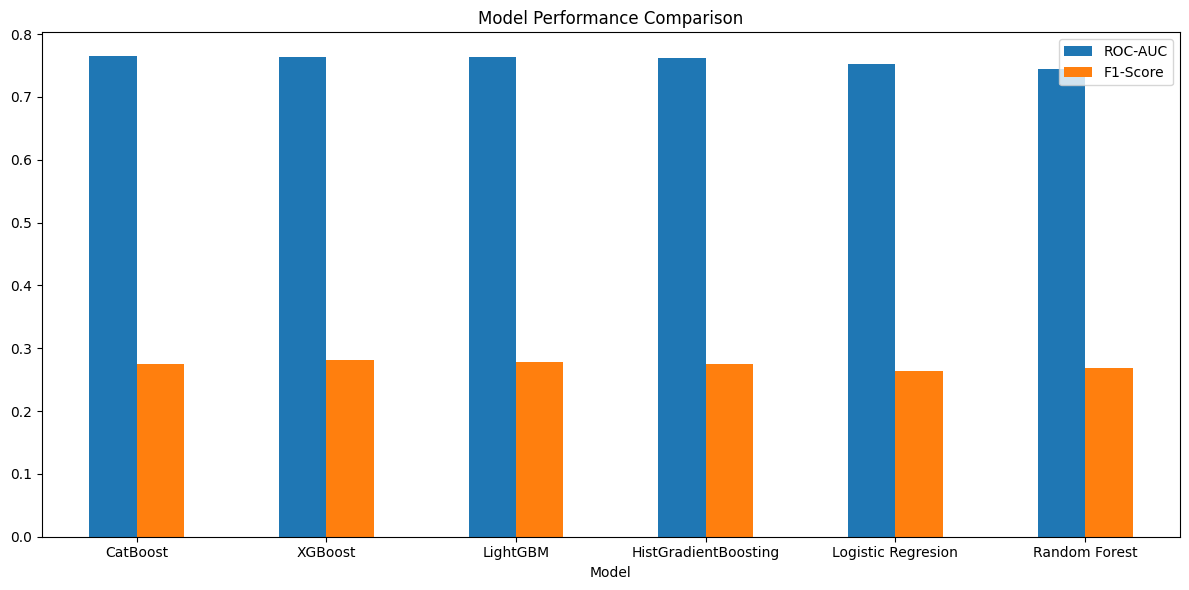

In [71]:
plt.figure(figsize=(8, 4))
results.plot(x="Model", y=["ROC-AUC", "F1-Score"], kind="bar", figsize=(12, 6))
plt.title("Model Performance Comparison")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

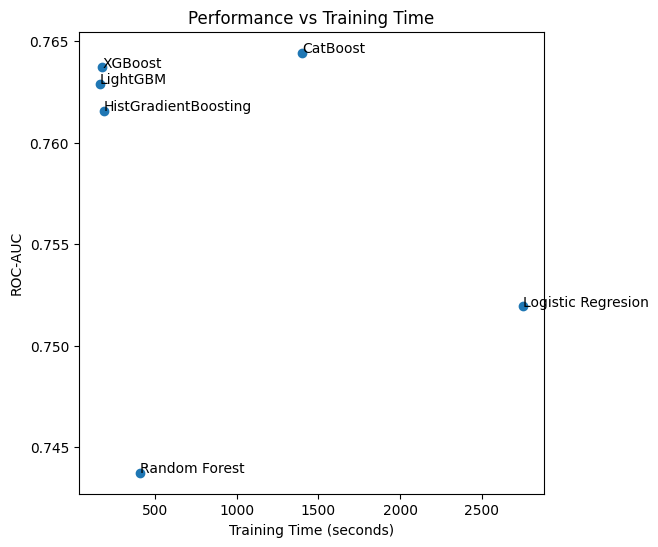

In [75]:
plt.figure(figsize=(6, 6))
plt.scatter(results["Time (seconds)"], results["ROC-AUC"])
for i, row in results.iterrows():
    plt.annotate(row["Model"], (row["Time (seconds)"], row["ROC-AUC"]))
plt.xlabel("Training Time (seconds)")
plt.ylabel("ROC-AUC")
plt.title("Performance vs Training Time")
plt.show()

In [76]:
results.to_csv("model_comparison_results_preprocessed.csv", index=False)

**Best model selection**

**Best AUC**: CatBoost edges out slightly, but only by ~0.001 compared to XGB - basically the same.

**Best PR-AUC**: LightGBM, XGBoost practically the same, CatBoost slightly worse. Very informative metric for imbalanced datasets.

**Best F1-Score**: XGBoost (0.2806) slightly better than LightGBM (0.2786) and CatBoost (0.2756).

**Runtime**: LightGBM is fastest (164s), XGBoost also quite fast (177s), CatBoost is very slow (1400s).

Random Forest & Logistic Regression clearly underperform.

HistGB is good but doesn’t beat LGBM/XGB.


**Best 2 Models:**

    1. LightGBM: Chosen for its near-top performance and exceptional speed.

    2. XGBoost: Selected for its slightly superior F1-Score and solid, stable performance.

Eventual backup Model:

    HistGradientBoosting - Good performance, adds diversity


CatBoost is great but too computationally heavy here (10× slower for ~0.001 improvement).

## 4. Merging external data

### A. Installments_payments dataset

**Numeric aggregation**

In [ ]:
num_aggs = {
    "AMT_INSTALMENT": ["mean", "max", "sum"],
    "AMT_PAYMENT": ["mean", "max", "sum"],
    "DAYS_INSTALMENT": ["mean", "max"],
    "DAYS_ENTRY_PAYMENT": ["mean", "max"],
}

**Must keep features**

    Worst delay, Worst underpayment ratio, Count of underpayments, Count of late payments.

In [ ]:
instal_must_keep = [
    "INSTAL_LATE_DAYS_max",
    "INSTAL_UNDERPAYMENT_RATIO_min",
    "INSTAL_UNDERPAYMENT_FLAG_sum",
    "INSTAL_LATE_FLAG_sum",
]

In [ ]:
train_df = train
instal_df = installments

selected_instal_features, importance_df = engineer_features_from_table_enhanced(
    main_df=train_df,
    auxiliary_df=instal_df,
    group_id="SK_ID_CURR",
    num_aggs=num_aggs,
    custom_funcs=[create_installment_custom_features],
    selection_method="adaptive",
    must_keep_list=instal_must_keep,
)

print(
    f"Generated {len(importance_df)} features, selected top {selected_instal_features.shape[1]-1}"
)
print("Top 5 features by combined rank:")
print(importance_df.head(5)[["feature", "lgb_importance", "roc_auc"]])

Generated 23 features, selected top 16
Top 5 features by combined rank:
                  feature  lgb_importance   roc_auc
1      AMT_INSTALMENT_max             222  0.487227
10   INSTAL_LATE_DAYS_max             210  0.500422
11  INSTAL_LATE_DAYS_mean             225  0.467356
12  INSTAL_LATE_FLAG_mean             238  0.455362
3        AMT_PAYMENT_mean             191  0.467648


### B. Bureau dataset

**Numeric aggregation**

In [ ]:
bureau_num_aggs = {
    "AMT_CREDIT_SUM": ["mean", "max", "sum"],
    "AMT_CREDIT_SUM_DEBT": ["mean", "max", "sum"],
    "AMT_CREDIT_SUM_OVERDUE": ["sum"],
    "YEARS_CREDIT": ["min", "max", "mean"],
    "YEARS_CREDIT_ENDDATE": ["min", "max", "mean"],
    "YEARS_CREDIT_UPDATE": [
        "min",
        "max",
        "mean",
    ],
}

**Must keep features**

    - Indicator if the client has ever had overdue debt in bureau records.

    – Flag showing whether the client has ever had overdue debt above a significant threshold.

    – Count of instances where the client was flagged with bad credit history.

    – Indicator for whether the client has ever triggered a major bureau risk flag.

    - Total amount of overdue credit across all bureau-reported loans.

In [ ]:
bureau_must_keep = [
    "BUREAU_HAS_ANY_OVERDUE_DEBT_max",
    "BUREAU_HAS_SIGNIFICANT_OVERDUE_DEBT_max",
    "BUREAU_HAS_BAD_CREDIT_sum",
    "BUREAU_HAS_ANY_MAJOR_BUREAU_RISK_max",
    "AMT_CREDIT_SUM_OVERDUE_sum",
]

In [ ]:
bureau_df = bureau
date_columns_b = ["DAYS_CREDIT_ENDDATE", "DAYS_ENDDATE_FACT", "DAYS_CREDIT_UPDATE"]
bureau_df = handle_date_anom_50(bureau_df, date_columns_b)
bureau_df = convert_days_to_years(bureau_df)

selected_bureau_features, bureau_importance_df = engineer_features_from_table_enhanced(
    main_df=train,
    auxiliary_df=bureau_df,
    group_id="SK_ID_CURR",
    num_aggs=bureau_num_aggs,
    custom_funcs=[create_bureau_custom_features],
    must_keep_list=bureau_must_keep,
    selection_method="adaptive",
)

print(
    f"Generated {len(bureau_importance_df)} features, selected top {selected_bureau_features.shape[1]-1}"
)
print("Top 5 features by combined rank:")
print(bureau_importance_df.head(5)[["feature", "lgb_importance", "roc_auc"]])

Force-adding must-keep feature: BUREAU_HAS_ANY_OVERDUE_DEBT_max
Force-adding must-keep feature: BUREAU_HAS_SIGNIFICANT_OVERDUE_DEBT_max
Force-adding must-keep feature: BUREAU_HAS_BAD_CREDIT_sum
Generated 29 features, selected top 23
Top 5 features by combined rank:
                           feature  lgb_importance   roc_auc
22  BUREAU_CREDIT_UTILIZATION_mean             159  0.564057
23   BUREAU_CREDIT_UTILIZATION_max             146  0.565434
0              AMT_CREDIT_SUM_mean             212  0.465789
1               AMT_CREDIT_SUM_max             193  0.469717
10        YEARS_CREDIT_ENDDATE_min             182  0.482543


### C. Bureau balance dataset

**Numeric aggregation**

In [ ]:
bb_num_aggs = {
    "BB_STATUS_SEVERITY_max": ["mean", "max"],
    "BB_STATUS_SEVERITY_last": ["mean", "max"],
    "BB_WAS_SEVERELY_DELINQUENT_max": "max",
    "BB_WAS_WRITTEN_OFF_max": "max",
    "BB_MONTHS_BALANCE_count": [
        "mean",
        "sum",
    ],
}

In [ ]:
bureau_balance_df = bureau_balance
bureau_df = bureau

bb_agg_features = create_bureau_balance_custom_features(bureau_balance_df)
bureau_enriched_df = bureau_df.merge(bb_agg_features, on="SK_ID_BUREAU", how="left")

selected_bb_features, bb_importance_df = engineer_features_from_table_enhanced(
    main_df=train_df,
    auxiliary_df=bureau_enriched_df,
    group_id="SK_ID_CURR",
    num_aggs=bb_num_aggs,
)

print(
    f"Generated {len(bb_importance_df)} features, selected top {selected_bb_features.shape[1]-1}"
)
print("Top 5 features by combined rank:")
print(bb_importance_df.head(5)[["feature", "lgb_importance", "roc_auc"]])

Generated 8 features, selected top 7
Top 5 features by combined rank:
                        feature  lgb_importance   roc_auc
0   BB_STATUS_SEVERITY_max_mean             694  0.513131
1    BB_STATUS_SEVERITY_max_max              91  0.512782
6  BB_MONTHS_BALANCE_count_mean            1131  0.492778
7   BB_MONTHS_BALANCE_count_sum            1047  0.496192
2  BB_STATUS_SEVERITY_last_mean              37  0.500071


### D. Credit card balance dataset

**Numerical aggregation**

In [ ]:
cc_num_aggs = {
    "MONTHS_BALANCE": ["min", "max", "size"],
    "AMT_DRAWINGS_ATM_CURRENT": ["sum", "max", "mean"],
    "AMT_DRAWINGS_OTHER_CURRENT": ["sum", "max", "mean"],
    "AMT_DRAWINGS_POS_CURRENT": ["sum", "max", "mean"],
    "AMT_PAYMENT_CURRENT": ["min", "sum", "mean"],
    "AMT_PAYMENT_TOTAL_CURRENT": ["min", "max", "sum", "mean"],
    "AMT_RECIVABLE": ["mean", "max", "sum"],
    "AMT_RECEIVABLE_PRINCIPAL": ["mean", "max"],
    "AMT_TOTAL_RECEIVABLE": ["mean", "max", "sum"],
    "CNT_DRAWINGS_ATM_CURRENT": ["sum", "max", "mean"],
    "CNT_DRAWINGS_OTHER_CURRENT": ["sum", "mean"],
    "CNT_DRAWINGS_POS_CURRENT": ["sum", "max", "mean"],
    "CNT_INSTALMENT_MATURE_CUM": ["mean", "max"],
}

**Must keep features**

    - Maximum number of days past due across all credit card statements.
    
    - Indicator if the client was ever delinquent (any overdue payments).
    
    – Indicator if the client was ever seriously delinquent (high days past due).
    
    – Maximum number of days past due on credit card accounts considered in default.

In [ ]:
cc_must_keep = [
    "CC_SK_DPD_max",
    "CC_IS_DELINQUENT_max",
    "CC_IS_SERIOUSLY_DELINQUENT_max",
    "CC_SK_DPD_DEF_max",
]

In [ ]:
cc_balance_df = credit_card_balance

selected_cc_features, cc_importance_df = engineer_features_from_table_enhanced(
    main_df=train_df,
    auxiliary_df=cc_balance_df,
    group_id="SK_ID_CURR",
    num_aggs=cc_num_aggs,
    custom_funcs=[create_cc_balance_custom_features],
    must_keep_list=cc_must_keep,
)

print(
    f"Generated {len(cc_importance_df)} features, selected top {selected_cc_features.shape[1]-1}"
)
print("Top 5 features by combined rank:")
print(cc_importance_df.head(5)[["feature", "lgb_importance", "roc_auc"]])

Force-adding must-keep feature: CC_SK_DPD_max
Force-adding must-keep feature: CC_IS_DELINQUENT_max
Force-adding must-keep feature: CC_IS_SERIOUSLY_DELINQUENT_max
Force-adding must-keep feature: CC_SK_DPD_DEF_max
Generated 73 features, selected top 39
Top 5 features by combined rank:
                             feature  lgb_importance   roc_auc
37  CC_CREDIT_UTILIZATION_RATIO_mean              88  0.531738
38   CC_CREDIT_UTILIZATION_RATIO_max             124  0.529827
29     CNT_DRAWINGS_ATM_CURRENT_mean              79  0.531547
58       CC_CNT_DRAWINGS_CURRENT_max              73  0.531339
57      CC_CNT_DRAWINGS_CURRENT_mean              71  0.532170


### E. Previous application dataset

**Numeric aggregation**

In [ ]:
prev_num_aggs = {
    "AMT_APPLICATION": ["mean", "max"],
    "AMT_CREDIT": ["mean", "max"],
    "AMT_ANNUITY": ["mean", "max"],
    "AMT_DOWN_PAYMENT": ["mean", "max"],
    "AMT_GOODS_PRICE": ["mean", "max"],
    "CNT_PAYMENT": ["mean", "max"],
    "YEARS_DECISION": ["min", "max", "mean"],
}

**Must keep features**

    - Total number of previous applications submitted by the client.
    
    – Number of approved previous applications.
    
    – Number of refused previous applications.
    
    – Ratio of approved applications to total applications.
    
    – Ratio of refused applications to total applications.
    
    – Ratio of refusals to approvals.
    
    – Average amount requested in previous applications.
    
    – Average credit amount granted in previous applications.
    
    – Average annuity value across previous applications.
    
    – Average down payment amount in previous applications.
    
    – Average goods price requested in previous applications.
    
    – Average number of installments across previous applications.
    
    – Average difference between requested and granted credit.
    
    – Average ratio of requested to granted credit.
    
    – Earliest (minimum) years since a previous decision.
    
    – Most recent (maximum) years since a previous decision.
    
    – Number of unique product types in previous contracts.

In [ ]:
prev_must_keep = [
    "PREV_APP_COUNT",
    "PREV_APP_APPROVED_COUNT",
    "PREV_APP_REFUSED_COUNT",
    "PREV_APPROVAL_RATE",
    "PREV_REFUSAL_RATE",
    "PREV_REFUSAL_TO_APPROVAL",
    "PREV_AMT_APPLICATION_mean",
    "PREV_AMT_CREDIT_mean",
    "PREV_AMT_ANNUITY_mean",
    "PREV_AMT_DOWN_PAYMENT_mean",
    "PREV_AMT_GOODS_PRICE_mean",
    "PREV_CNT_PAYMENT_mean",
    "PREV_APP_CREDIT_DIFF_mean",
    "PREV_APP_CREDIT_RATIO_mean",
    "PREV_YEARS_DECISION_min",
    "PREV_YEARS_DECISION_max",
    "PREV_NAME_CONTRACT_TYPE_PRODUCT_DIVERSITY",
]

In [ ]:
prev_app_df = prev.copy()
date_columns_prev = [
    "DAYS_FIRST_DRAWING",
    "DAYS_FIRST_DUE",
    "DAYS_LAST_DUE_1ST_VERSION",
    "DAYS_LAST_DUE",
    "DAYS_TERMINATION",
]
prev_app_df = handle_date_anom_1000(prev_app_df, date_columns_prev)
prev_app_df = convert_days_to_years(prev_app_df)

selected_prev_features, prev_importance_df = engineer_features_from_table_enhanced(
    main_df=train_df,
    auxiliary_df=prev_app_df,
    group_id="SK_ID_CURR",
    num_aggs=prev_num_aggs,
    custom_funcs=[create_prev_app_custom_features_balanced],
    must_keep_list=prev_must_keep,
)

print(
    f"Generated {len(prev_importance_df)} features, selected top {selected_prev_features.shape[1]-1}"
)
print("Top 5 features by combined rank:")
print(prev_importance_df.head(5)[["feature", "lgb_importance", "roc_auc"]])

Force-adding must-keep feature: PREV_APP_APPROVED_COUNT
Force-adding must-keep feature: PREV_APP_REFUSED_COUNT
Force-adding must-keep feature: PREV_APPROVAL_RATE
Force-adding must-keep feature: PREV_REFUSAL_RATE
Force-adding must-keep feature: PREV_AMT_APPLICATION_mean
Force-adding must-keep feature: PREV_AMT_CREDIT_mean
Force-adding must-keep feature: PREV_AMT_ANNUITY_mean
Force-adding must-keep feature: PREV_AMT_DOWN_PAYMENT_mean
Force-adding must-keep feature: PREV_AMT_GOODS_PRICE_mean
Force-adding must-keep feature: PREV_CNT_PAYMENT_mean
Force-adding must-keep feature: PREV_YEARS_DECISION_min
Force-adding must-keep feature: PREV_YEARS_DECISION_max
Generated 48 features, selected top 36
Top 5 features by combined rank:
                       feature  lgb_importance   roc_auc
25   PREV_APP_CREDIT_RATIO_max             182  0.560592
10            CNT_PAYMENT_mean             165  0.529602
23  PREV_APP_CREDIT_RATIO_mean             103  0.573992
24   PREV_APP_CREDIT_RATIO_min          

### F. POS CASH balance dataset

**Numeric aggregation**

In [ ]:
pos_num_aggs = {
    "CNT_INSTALMENT": ["mean", "max"], 
    "CNT_INSTALMENT_FUTURE": ["mean", "min", "max"],
    "MONTHS_BALANCE": ["min", "max", "mean"],
}

**Must keep features**

    - Maximum number of days past due across POS cash loans.
    
    – Flag if the client was ever delinquent on POS loans.
    
    – Flag if the client was ever seriously delinquent.
    
    – Maximum number of days past due with default-level severity.
    
    - Average ratio of completed installments to total installments.
    
    – Flag if any POS loan was fully completed.

In [ ]:
pos_must_keep = [
    "POS_SK_DPD_max",
    "POS_IS_DELINQUENT_max",
    "POS_IS_SERIOUSLY_DELINQUENT_max",
    "POS_SK_DPD_DEF_max",
    "POS_INSTALMENTS_COMPLETED_RATIO_mean",
    "POS_IS_COMPLETED_max",
]

In [ ]:
pos_cash_df = pos

selected_pos_features, pos_importance_df = engineer_features_from_table_enhanced(
    main_df=train_df,
    auxiliary_df=pos_cash_df,
    group_id="SK_ID_CURR",
    num_aggs=pos_num_aggs,
    custom_funcs=[create_pos_cash_custom_features],
    must_keep_list=pos_must_keep,
)

print(
    f"Generated {len(pos_importance_df)} features, selected top {selected_pos_features.shape[1]-1}"
)
print("Top 5 features by combined rank:")
print(pos_importance_df.head(5)[["feature", "lgb_importance", "roc_auc"]])

Force-adding must-keep feature: POS_IS_DELINQUENT_max
Force-adding must-keep feature: POS_IS_SERIOUSLY_DELINQUENT_max
Force-adding must-keep feature: POS_IS_COMPLETED_max
Generated 23 features, selected top 19
Top 5 features by combined rank:
                feature  lgb_importance   roc_auc
7   MONTHS_BALANCE_mean             332  0.533524
5    MONTHS_BALANCE_min             267  0.546719
0   CNT_INSTALMENT_mean             325  0.520113
9       POS_SK_DPD_mean             159  0.525103
13  POS_SK_DPD_DEF_mean             140  0.525471


### F. Data Integration

The main **train and test** datasets will now be joined with the newly created features to form a single, comprehensive datasets ready for model training

In [ ]:
all_selected_features = [
    selected_instal_features,
    selected_bureau_features,
    selected_bb_features,
    selected_cc_features,
    selected_prev_features,
    selected_pos_features,
]

train_df_enriched = train.copy()
for feature_df in all_selected_features:
    train_df_enriched = train_df_enriched.merge(feature_df, on="SK_ID_CURR", how="left")

print(f"Final enriched shape: {train_df_enriched.shape}")

Final enriched shape: (307511, 284)


In [ ]:
test_df_enriched = test.copy()
for feature_df in all_selected_features:
    test_df_enriched = test_df_enriched.merge(feature_df, on="SK_ID_CURR", how="left")

print(f"Final test enriched shape: {test_df_enriched.shape}")

Final test enriched shape: (48744, 283)


**Donwcasting numeric columns**

In [ ]:
train_df_enriched = downcast_numeric_col(train_df_enriched)
test_df_enriched = downcast_numeric_col(test_df_enriched)

**Saving datasets to parquet**

In [ ]:
train_df_enriched.to_parquet("train_enriched_284.parquet", engine="fastparquet")
test_df_enriched.to_parquet("test_enriched_283.parquet", engine="fastparquet")

## 5. LightGBM and XGBoost training on merged dataset (284 features)

### A. Splitting dataset & pipeline preprocessing 

**Loading datasets**

In [4]:
train_df_enriched = pd.read_parquet("train_enriched_284.parquet")
test_df_enriched = pd.read_parquet("test_enriched_283.parquet")
train_df_enriched.shape

(307511, 284)

**Splitting Train dataset**

In [5]:
X = train_df_enriched.drop(columns=["TARGET", "SK_ID_CURR"], errors="ignore")
y = train_df_enriched["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scale_pos_weight = (y == 0).sum() / (y == 1).sum()

print(f"Train: {X_train.shape[0]} samples, Test: {X_test.shape[0]} samples")

Train: 246008 samples, Test: 61503 samples


**Defining preprocesor**

In [6]:
numeric = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

cat_pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        (
            "ordinal",
            OrdinalEncoder(
                handle_unknown="use_encoded_value",
                unknown_value=-1,
                encoded_missing_value=-2,
            ),
        ),
    ]
)

num_pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
    ]
)

preprocessor = ColumnTransformer(
    [("num", num_pipe, numeric), ("cat", cat_pipe, categorical)]
)

### B. LightGBM model

In [10]:
model_lgbm = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "classifier",
            LGBMClassifier(
                random_state=42,
                n_estimators=500,
                verbose=-1,
                learning_rate=0.05,
                max_depth=5,
                subsample=0.8,
                min_child_samples=100,
                scale_pos_weight=scale_pos_weight,
            ),
        ),
    ]
)

In [12]:
start_time = time.time()

y_probs = cross_val_predict(model_lgbm, X_train, y_train, cv=5, method="predict_proba")[
    :, 1
]

y_pred = (y_probs >= 0.5).astype(int)

elapsed_time_lgbm = time.time() - start_time

print(classification_report(y_train, y_pred))

roc_auc_lgbm = roc_auc_score(y_train, y_probs)
f1_lgbm = f1_score(y_train, y_pred)
pr_auc_lgbm = average_precision_score(y_train, y_probs)
print(f"Mean ROC AUC: {roc_auc_lgbm:.4f}")
print(f"F1 Score: {f1_lgbm:.4f}")
print(f"PR-AUC: {pr_auc_lgbm:.4f}")

print(f"\nTotal time taken: {elapsed_time_lgbm:.2f} seconds")

              precision    recall  f1-score   support

           0       0.96      0.76      0.85    226148
           1       0.19      0.67      0.30     19860

    accuracy                           0.75    246008
   macro avg       0.58      0.71      0.57    246008
weighted avg       0.90      0.75      0.80    246008

Mean ROC AUC: 0.7845
F1 Score: 0.3007
PR-AUC: 0.2756

Total time taken: 498.13 seconds


Noticeable increase in all metrics (except training time), compared to result before merging features from additional datasets:

    ROC-AUC - 0.7845 (on train dataset was 0.7629) - Main metric.
    F1-score - 0.3 (0.2786) - Balances precision and recall; low due to low precision but moderate recall.
    PR-AUC - 0.2756 (0.247) - Indicates modest performance in identifying positive cases, important because the dataset is imbalanced. This is typical for imbalanced datasets where catching most positives often comes at the cost of many false positives.

### C. XGBoost model

In [11]:
model_xgb = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "classifier",
            XGBClassifier(
                random_state=42,
                n_estimators=500,
                learning_rate=0.05,
                max_depth=5,
                subsample=0.8,
                colsample_bytree=0.8,
                scale_pos_weight=scale_pos_weight,
                verbosity=0,
                use_label_encoder=False,
                eval_metric="auc",
            ),
        ),
    ]
)

In [14]:
start_time = time.time()

y_probs = cross_val_predict(model_xgb, X_train, y_train, cv=5, method="predict_proba")[
    :, 1
]

y_pred = (y_probs >= 0.5).astype(int)

elapsed_time_xgb = time.time() - start_time
roc_auc_xgb = roc_auc_score(y_train, y_probs)
f1_xgb = f1_score(y_train, y_pred)
pr_auc_xgb = average_precision_score(y_train, y_probs)

print(classification_report(y_train, y_pred))
print(f"Mean ROC AUC: {roc_auc_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")
print(f"PR-AUC: {pr_auc_xgb:.4f}")
print(f"\nTotal time taken: {elapsed_time_xgb:.2f} seconds")

              precision    recall  f1-score   support

           0       0.96      0.77      0.85    226148
           1       0.20      0.66      0.30     19860

    accuracy                           0.76    246008
   macro avg       0.58      0.71      0.58    246008
weighted avg       0.90      0.76      0.81    246008

Mean ROC AUC: 0.7847
F1 Score: 0.3034
PR-AUC: 0.2752

Total time taken: 406.98 seconds


XGBoost performs similarly to LightGBM — achieving good recall and discrimination (ROC-AUC) but with low precision, highlighting the common trade-off on imbalanced datasets. Increase in all main metrics:

    ROC-AUC - 0.7847 (on train dataset was 0.7637): Strong ability to distinguish between classes.
    F1-score - 0.3 (0.28): Balanced measure is modest, limited by low precision.
    PR-AUC - 0.2752 (0.247): Moderate effectiveness in handling the minority class.. 


**Key Insights:**

    XGBoost (AUC 0.7847, F1 0.3034, PR-AUC 0.2752, 407s)
    Strong performance with slightly faster training time. Good balance of speed and predictive power.

    LightGBM (AUC 0.7845, F1 0.3007, PR-AUC 0.2756, 498s)
    Nearly identical performance metrics, with marginally higher PR-AUC but slower training.

Both models perform almost the same in terms of predictive quality. XGBoost is more efficient, while LightGBM provides a tiny F1 boost at the cost of longer runtime.

### D. Feature selection

We will leverage the **feature importances from LightGBM model** to perform feature segregation and selection.

This method is highly effective because tree-based models, like LightGBM, inherently rank features based on their contribution to the model's predictive power. By analyzing these importance scores, we can **identify and prioritize the most influential features** while filtering out those that add little to no value. This process will create a more concise and powerful feature set for our final model.

In [15]:
warnings.filterwarnings("ignore")

model_fs = LGBMClassifier(
    random_state=42,
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    min_child_samples=100,
    n_jobs=-1,
    verbose=-1,
)

X_train_lgb = X_train.copy()
for col in categorical:
    X_train_lgb[col] = X_train_lgb[col].astype("category")

model_fs.fit(X_train_lgb, y_train, categorical_feature=categorical)

importances = pd.Series(
    model_fs.feature_importances_, index=X_train.columns
).sort_values(ascending=False)
print(importances.head(25))

ORGANIZATION_TYPE                       1371
EXT_SOURCE_MEAN                          293
ANNUITY_TO_CREDIT                        283
YEARS_BIRTH                              225
AMT_ANNUITY                              195
EXT_SOURCE_2_3                           176
OCCUPATION_TYPE                          172
LTV_RATIO                                162
POS_INSTALMENTS_COMPLETED_RATIO_mean     161
BUREAU_CREDIT_UTILIZATION_max            152
EXT_SOURCE_3                             150
YEARS_CREDIT_ENDDATE_min                 149
AMT_PAYMENT_sum                          143
EXT_SOURCE_STD                           142
YEARS_EMPLOYED                           141
EXT_SOURCE_1                             140
EXT_SOURCE_2                             138
YEARS_CREDIT_min                         136
YEARS_ID_PUBLISH                         136
INSTAL_LATE_FLAG_mean                    135
DTI_RATIO                                134
EMPLOY_AGE_RATIO                         122
INSTAL_LAT

**Top 25 Phik correlations** (train only) vs. **Top 25 LightGBM** feature importances (train + additional datasets)

**Common features (appear in both lists, strongest predictors):**
    
    EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3 - strong predictors of credit risk.
    
    YEARS_BIRTH, YEARS_EMPLOYED, YEARS_ID_PUBLISH - demographic & stability indicators.
    
    OCCUPATION_TYPE, ORGANIZATION_TYPE - socioeconomic status signals.

**Present in Phik only:**

    Features related to anomalies, flags, and housing (e.g., ANOM_DAYS_EMPLOYED, REG_CITY_NOT_WORK_CITY, FLAG_DOCUMENT_3, HOUSETYPE_MODE, WALLSMATERIAL_MODE, BUILDING_INFO_MISSING_COUNT, NAME_FAMILY_STATUS).
    These capture categorical / structural data quirks, less emphasized by boosting models.

**Present in LightGBM only:**

    Engineered ratios and cross-dataset features (e.g., EXT_SOURCE_MEAN, EXT_SOURCE_STD, EXT_SOURCE_2_3, LTV_RATIO, DTI_RATIO, EMPLOY_AGE_RATIO, POS_INSTALMENTS_COMPLETED_RATIO_mean, BUREAU_CREDIT_UTILIZATION_max, INSTAL_LATE_FLAG features, AMT_PAYMENT_sum).
    
*The Phik correlation analysis could not evaluate the importance* of these features because they are engineered or cross-dataset features that were not present in the main training dataset at the time of the calculation.

**Number of features with importance > 0**

Checking number of features with importance higher that 0.

In [63]:
selected_features = importances[importances > 0].index.tolist()
print(f"Features kept: {len(selected_features)}")

X_train_sel = X_train[selected_features]

Features kept: 222


**ROC-AUC for selected top features**

To optimize our model, we'll analyze how the number of features impacts performance. We'll train a LightGBM model on datasets containing the top features, checking the ROC-AUC score for different feature counts. This process will help us find the optimal number of features that maximizes the model's predictive power without including noise. We'll specifically evaluate the **top 140, 170, 200, 222** features based on their LightGBM importance scores.

In [69]:
top_features_list = [140, 170, 200, 222]

for n in top_features_list:
    selected = importances.head(n).index.tolist()
    X_sel = X_train[selected]

    numerical = X_sel.select_dtypes(include=[np.number]).columns.tolist()
    categorical = X_sel.select_dtypes(exclude=[np.number]).columns.tolist()

    cat_pipe = Pipeline(
        [
            ("imputer", SimpleImputer(strategy="most_frequent")),
            (
                "ordinal",
                OrdinalEncoder(
                    handle_unknown="use_encoded_value",
                    unknown_value=-1,
                    encoded_missing_value=-2,
                ),
            ),
        ]
    )

    num_pipe = Pipeline(
        [("imputer", SimpleImputer(strategy="median", add_indicator=True))]
    )

    preprocessor = ColumnTransformer(
        [("num", num_pipe, numerical), ("cat", cat_pipe, categorical)]
    )

    scale_pos_weight = (y == 0).sum() / (y == 1).sum()

    model_lgbm = Pipeline(
        [
            ("preprocessor", preprocessor),
            (
                "classifier",
                LGBMClassifier(
                    random_state=42,
                    n_estimators=500,
                    verbose=-1,
                    learning_rate=0.0438,
                    max_depth=8,
                    subsample=0.79,
                    min_child_samples=524,
                    colsample_bytree=0.634,
                    scale_pos_weight=scale_pos_weight,
                ),
            ),
        ]
    )

    start_time = time.time()

    y_probs = cross_val_predict(
        model_lgbm, X_sel, y_train, cv=3, method="predict_proba"
    )[:, 1]
    y_pred = (y_probs >= 0.5).astype(int)

    elapsed_time_lgbm = time.time() - start_time
    roc_auc_lgbm = roc_auc_score(y_train, y_probs)

    print(f"\n Top {n} Mean ROC AUC: {roc_auc_lgbm:.4f}")
    print(f"Total time taken: {elapsed_time_lgbm:.2f} seconds")


 Top 140 Mean ROC AUC: 0.7849
Total time taken: 146.78 seconds

 Top 170 Mean ROC AUC: 0.7856
Total time taken: 151.77 seconds

 Top 200 Mean ROC AUC: 0.7856
Total time taken: 158.28 seconds

 Top 222 Mean ROC AUC: 0.7852
Total time taken: 170.53 seconds


Based on results, the most optimal feature selection is the **top 170 features**, which yielded a mean ROC-AUC score of 0.7856. While using 200 features produced the same score, the added features did not improve performance. In contrast, using more features (222) actually led to a slight decrease in the ROC-AUC score, suggesting the inclusion of irrelevant or noisy features.

**Saving importances**

In [13]:
importances.to_csv("lgbm_importances.csv", header=["importance"])

In [7]:
importances = pd.read_csv("../Deploy/lgbm_importances.csv", index_col=0).squeeze("columns")
len(importances)

282

### D. Optuna hyperparameter optimization for LightGBM and XGBoost models

**The hyperparameter optimization** for both the LightGBM and XGBoost models was conducted **using Optuna**, a powerful open-source hyperparameter optimization framework, was executed in Google Colab. Due to the computational demands and occasional server disconnections (GPU accelerator (5x faster than CPU) was available for 1,5 hour) in the Google Colab environment, the optimization process was broken down into multiple stages:

    Initial Exploration: The first stage involved a broad search across a wide range of hyperparameters to identify promising regions of the search space. A high number of n_startup_trials (30-50) was used to ensure comprehensive initial exploration.

    Fine-tuning: Subsequent optimization runs, often initiated after a disconnection, focused on a narrower hyperparameter range centered around the best trials found in the previous stage. This allowed for more granular fine-tuning without the need for a startup phase.

The entire optimization process, including model installations, data loading, and optimization code, is detailed in the notebook: 

    Data\Optuna_lgbm_xgb_goggle_colab.ipynb

Here is an example code for last xgb model tuning.

In [ ]:
categorical_cols = X_train170.select_dtypes(exclude=["number"]).columns
numeric_cols = X_train170.select_dtypes(include=["number"]).columns

encoder = TargetEncoder(cols=categorical_cols)
X_train_encoded = encoder.fit_transform(X_train170, y_train)

X_opt = X_train_encoded.copy()
y_opt = y_train.copy()

X_train_opt, X_valid_opt, y_train_opt, y_valid_opt = train_test_split(
    X_opt, y_opt, test_size=0.2, stratify=y_opt, random_state=42
)

scale_pos_weight = (y_opt == 0).sum() / (y_opt == 1).sum()

def objective(trial):
    param = {
        "n_estimators": 500,
        "tree_method": "hist",
        "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.06),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "min_child_weight": trial.suggest_int("min_child_weight", 3, 20),
        "subsample": trial.suggest_float("subsample", 0.6, 0.8),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 0.8),
        "scale_pos_weight": scale_pos_weight,
        "random_state": 42,
        "eval_metric": "auc",
        "use_label_encoder": False,
        "verbosity": 0,
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for train_idx, valid_idx in cv.split(X_opt, y_opt):

        X_train_cv, X_valid_cv = X_opt.iloc[train_idx], X_opt.iloc[valid_idx]
        y_train_cv, y_valid_cv = y_opt.iloc[train_idx], y_opt.iloc[valid_idx]

        preprocessor170.fit(X_train_cv, y_train_cv)

        X_train_cv_transformed = preprocessor170.transform(X_train_cv)
        X_valid_cv_transformed = preprocessor170.transform(X_valid_cv)

        model = XGBClassifier(**param)
        model.fit(X_train_cv_transformed, y_train_cv)

        preds = model.predict_proba(X_valid_cv_transformed)[:, 1]
        score = roc_auc_score(y_valid_cv, preds)
        scores.append(score)

    return np.mean(scores)


study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(n_startup_trials=0, seed=42),
)

start_time = time.time()
study.optimize(objective, n_trials=150, show_progress_bar=True)
elapsed_time = time.time() - start_time

**Best results and best params**

In [9]:
lgbm_best_result = pd.read_json(r"../Data/lgbm_best_result.json")
xgb_best_result = pd.read_json(r"../Data/xgb_best_result.json")

In [10]:
lgbm_best_result

,best_value,best_params
learning_rate,0.787908,0.040013
max_depth,0.787908,9.000000
min_child_samples,0.787908,644.000000
subsample,0.787908,0.687133
colsample_bytree,0.787908,0.602445


In [11]:
xgb_best_result

,best_value,best_params
learning_rate,0.78743,0.051778
max_depth,0.78743,4.000000
min_child_weight,0.78743,18.000000
subsample,0.78743,0.729937
colsample_bytree,0.78743,0.740587


## 6. LightGBM and XGBoost models performance on top 170 selected features and best params

**Redefining preprocessor**

In [8]:
selected = importances.head(170).index.tolist()
X_train170 = X_train[selected]

numerical = X_train170.select_dtypes(include=[np.number]).columns.tolist()
categorical = X_train170.select_dtypes(exclude=[np.number]).columns.tolist()

num_pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
        ("scaler", StandardScaler()),
    ]
)

cat_pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        (
            "ordinal",
            OrdinalEncoder(
                handle_unknown="use_encoded_value",
                unknown_value=-1,
                encoded_missing_value=-2,
            ),
        ),
    ]
)

preprocessor170 = ColumnTransformer(
    [("num", num_pipe, numerical), ("cat", cat_pipe, categorical)]
)

### A. LightGBM with best Optuna params

In [9]:
lgbm_best_params = {
    "random_state": 42,
    "n_estimators": 500,
    "learning_rate": 0.040013316682136535,
    "max_depth": 9,
    "subsample": 0.6871333752936252,
    "colsample_bytree": 0.602444705291564,
    "min_child_samples": 644,
    "scale_pos_weight": scale_pos_weight,
    "verbose": -1,
}

model_lgbm_best = Pipeline(
    [
        ("preprocessor", preprocessor170),
        ("classifier", LGBMClassifier(**lgbm_best_params)),
    ]
)

In [14]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

start_time = time.time()

y_probs = cross_val_predict(
    model_lgbm_best, X_train170, y_train, cv=cv, method="predict_proba"
)[:, 1]
y_pred = (y_probs >= 0.5).astype(int)

elapsed_time = time.time() - start_time

roc_auc = roc_auc_score(y_train, y_probs)
f1 = f1_score(y_train, y_pred)
pr_auc = average_precision_score(y_train, y_probs)

print(classification_report(y_train, y_pred))
print(f"Mean ROC AUC: {roc_auc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")
print(f"\nTotal time taken: {elapsed_time:.2f} seconds")

              precision    recall  f1-score   support

           0       0.96      0.75      0.84    226148
           1       0.19      0.68      0.30     19860

    accuracy                           0.75    246008
   macro avg       0.58      0.72      0.57    246008
weighted avg       0.90      0.75      0.80    246008

Mean ROC AUC: 0.7881
F1 Score: 0.3016
PR-AUC: 0.2784

Total time taken: 337.99 seconds


**LightGBM - 170 Selected Features after Optuna** (comparison with results for 282 features before Optuna):

    ROC-AUC: 0.7881 (+0.0036)
    
    F1: 0.3016 (+0.0009)
    
    PR-AUC: 0.2784 (+0.0028)
    
    Time: 338s (-160s)

**Slight improvement across ROC-AUC, F1, and PR-AUC** despite using fewer features. Optimization seems to have refined the model’s balance between recall and precision and noticeable decreased time of training.

Feature selection (170 top features) combined with Optuna tuning provided a small but consistent performance gain compared to the full 284-feature model.

**Saving LGBM model's predictions for submission**

In [82]:
X_test170 = test_df_enriched[selected]
test_ids = test_df_enriched["SK_ID_CURR"]

model_lgbm_best.fit(X_train170, y_train)

y_test_probs = model_lgbm_best.predict_proba(X_test170)[:, 1]

submission = pd.DataFrame({"SK_ID_CURR": test_ids, "TARGET": y_test_probs})
submission.to_csv("submission_lgbm_170.csv", index=False)

print("✅ Submission file saved as submission_lgbm_170.csv")

✅ Submission file saved as submission_lgbm_170.csv


Kaggle result **0.78515**

### B. XGBoost with best Optuna params

In [10]:
xgb_best_params = {
    "random_state": 42,
    "n_estimators": 500,
    "learning_rate": 0.051778087186019034,
    "max_depth": 4,
    "min_child_weight": 18,
    "subsample": 0.729936556487968,
    "colsample_bytree": 0.7405870568750555,
    "scale_pos_weight": scale_pos_weight,
    "verbosity": 0,
    "eval_metric": "auc",
}

model_xgb_best = Pipeline(
    [
        ("preprocessor", preprocessor170),
        ("classifier", XGBClassifier(**xgb_best_params)),
    ]
)

In [15]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

start_time = time.time()
y_probs_xgb = cross_val_predict(
    model_xgb_best, X_train170, y_train, cv=cv, method="predict_proba"
)[:, 1]
y_pred_xgb = (y_probs_xgb >= 0.5).astype(int)
elapsed_time_xgb = time.time() - start_time

roc_auc_xgb = roc_auc_score(y_train, y_probs_xgb)
f1_xgb = f1_score(y_train, y_pred_xgb)
pr_auc_xgb = average_precision_score(y_train, y_probs_xgb)

print(classification_report(y_train, y_pred_xgb))
print(f"Mean ROC AUC: {roc_auc_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")
print(f"PR-AUC: {pr_auc_xgb:.4f}")
print(f"Total time taken: {elapsed_time_xgb:.2f} seconds")

              precision    recall  f1-score   support

           0       0.96      0.74      0.84    226148
           1       0.19      0.69      0.30     19860

    accuracy                           0.74    246008
   macro avg       0.58      0.71      0.57    246008
weighted avg       0.90      0.74      0.80    246008

Mean ROC AUC: 0.7863
F1 Score: 0.2975
PR-AUC: 0.2767
Total time taken: 361.42 seconds


**XGBoost - 170 Selected Features after Optuna** (comparison with results for 282 features before Optuna):
    
    ROC-AUC: very small improvement 0.7863 (+ 0.0016).
    
    F1-score: slightly decreased 0.2975 (-0.0059).
    
    PR-AUC: almost unchanged 0.2767 (+ 0.0015).
    
    Training time: significantly reduced 318.43s (- 46s).

XGBoost has less reduced training time than LGBM and less predictive performance gains. The optimization with fewer features slightly stabilized ROC-AUC/PR-AUC but at the expense of F1.

**Saving XGB model's predictions for submission**

In [83]:
model_xgb_best.fit(X_train170, y_train)

y_test_probs = model_xgb_best.predict_proba(X_test170)[:, 1]

submission = pd.DataFrame({"SK_ID_CURR": test_ids, "TARGET": y_test_probs})
submission.to_csv("submission_xgb_170.csv", index=False)

print("✅ Submission file saved as submission_xgb_170.csv")

✅ Submission file saved as submission_xgb_170.csv


Kaggle result **0.78323**

### C. ROC and Precision–Recall Curves

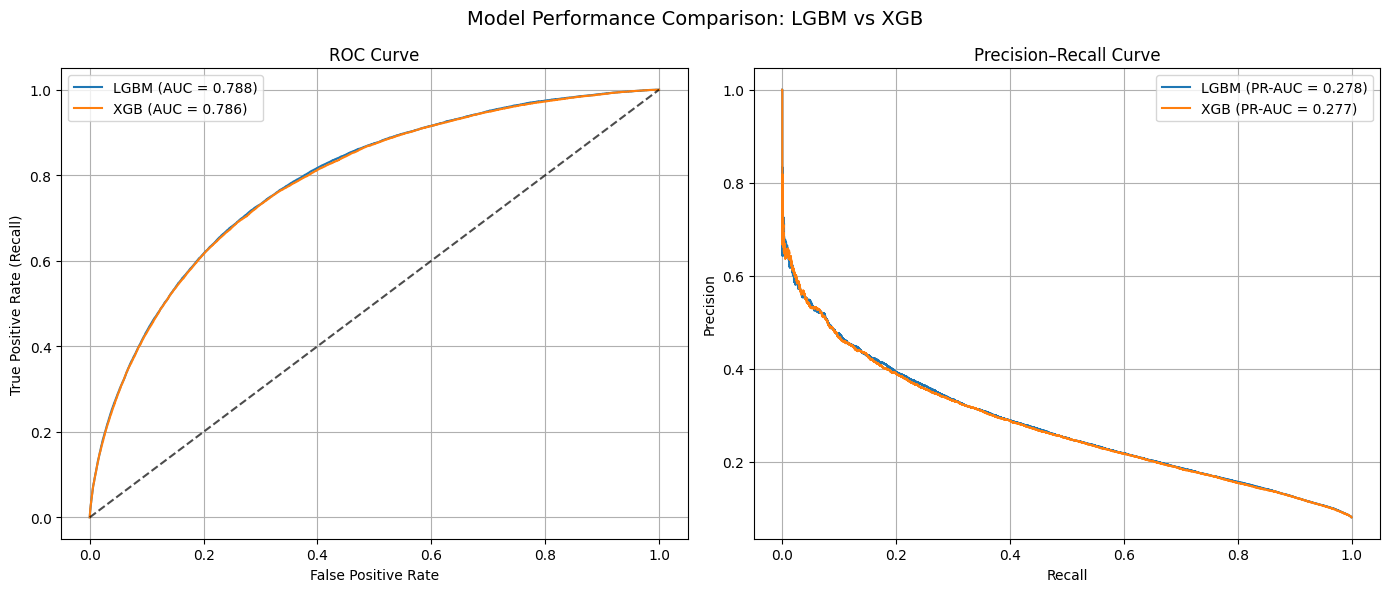

In [16]:
plot_roc_pr_curves(y_train, y_probs, y_probs_xgb, model_names=("LGBM", "XGB"))

**ROC AUC ~0.788 (LGBM) vs 0.786 (XGB):** Both models have almost identical discriminative ability. ROC AUC is main metric, so this shows either model is strong at ranking positives vs negatives.

    LGBM slightly outperforms XGB on ROC AUC, but difference is marginal.

**The precision–recall curves for LGBM and XGB show a clear trade-off between precision and recall**, which is common in highly imbalanced datasets. At very low recall levels (around 0.03), precision is relatively high (~0.6), meaning that when the model predicts a positive case, it is usually correct. However, this comes at the cost of missing most of the actual positives.

    This downward slope indicates that in order to capture more true positives, the models also accumulate more false positives, which lowers precision.

Because the dataset is imbalanced, the PR curve and PR-AUC are more informative than ROC-AUC. Here, the curves suggest that while both models perform above random guessing, there is a strong precision–recall trade-off: achieving high recall inevitably comes with very low precision.

In practice, the optimal decision threshold would depend on the business objective - whether minimizing false positives or maximizing recall is more important.

The shapes of the curves for both LGBM and XGB are very similar, showing that the **both models are nearly equivalent in performance.**

### D. Calibration Curves for LightGBM and XGBoost

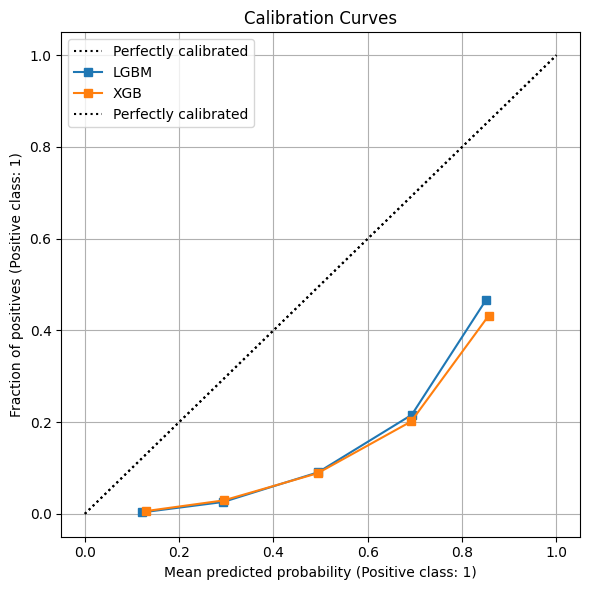

In [19]:
model_lgbm_best.fit(X_train170, y_train)
model_xgb_best.fit(X_train170, y_train)

plot_calibration_curves(
    [("LGBM", model_lgbm_best), ("XGB", model_xgb_best)],
    X_train170,
    y_train,
    figsize=(6, 6),
)

Calibration plot shows that **two models systematically overestimates probabilities** (e.g. predicted 0.8 corresponds to only ~0.38 (~55%) true rate).
This means the raw probability values are not reliable as absolute risk estimates.

However, since main **metric is ROC-AUC**, this miscalibration is not critical, because ROC-AUC depends only on the ranking of predictions, not their absolute values.

The model is well ranked (good ROC-AUC), but poorly calibrated. If we would need better PR-AUC and F1-score calibration would be necessary.

### E. SHAP feature importances

**LightGBM model**

 99%|===================| 988/1000 [00:37<00:00]        

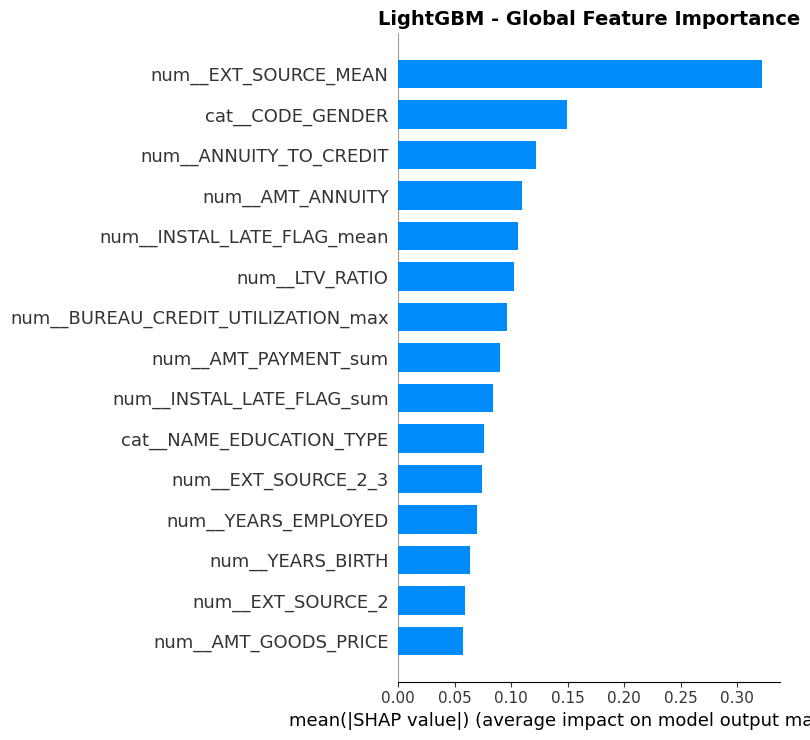

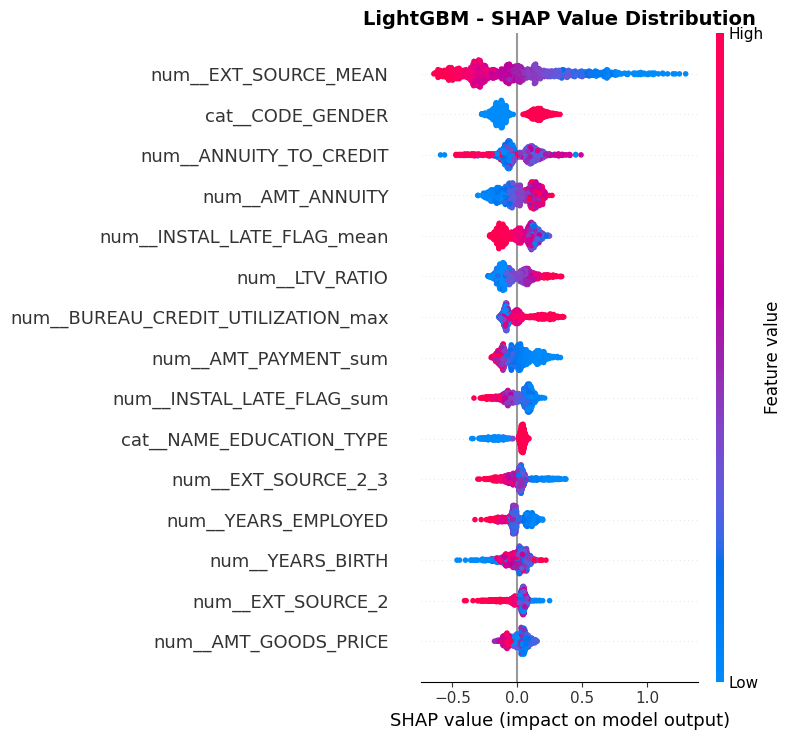

In [23]:
shap_lgbm, lgbm_feature_names, shap_lgbm_top20 = analyze_shap_separate_plots(
    model_lgbm_best, X_train170, "LightGBM"
)

In [24]:
shap_lgbm_top20[:5]

num__EXT_SOURCE_MEAN          0.322026
cat__CODE_GENDER              0.149325
num__ANNUITY_TO_CREDIT        0.121517
num__AMT_ANNUITY              0.109450
num__INSTAL_LATE_FLAG_mean    0.105579
dtype: float64

**Top 5 LGBM SHAP results**

**num__EXT_SOURCE_MEAN – SHAP: 0.344 (highest)**

    Lower external scores (e.g., EXT_SOURCE_1/2/3) increase default risk.
    
    Higher external scores decrease default risk.
    
        External scoring metrics are predictive of creditworthiness; low scores - higher risk.

**cat__CODE_GENDER – SHAP: 0.147**

    Blue (0) = Female (F) - negative SHAP, Red (1) = Male (M) - positive SHAP.

    Males tend to have slightly higher predicted default probability.
    
    Females tend to slightly lower predicted default probability.

**num__ANNUITY_TO_CREDIT – SHAP: 0.118**

    Highly mixed colors, but high red values - negative SHAP

    Ratio of annuity to credit amount matters, but effect is non-linear.

**num__AMT_ANNUITY – SHAP: 0.107**

    Low values - negative SHAP, high (red) - positive SHAP
    
    Smaller monthly payments (annuities) slightly reduce default probability.
    
    Larger monthly payments increase default probability, likely reflecting financial stress or larger loans relative to income.

**num__INSTAL_LATE_FLAG_mean – SHAP: 0.106**

    High values - negative SHAP, Blue/low - positive SHAP

    Higher historical installment lateness reduces predicted default?

    Low lateness (blue) increases predicted default?

    This seems counterintuitive; could be an artifact of feature engineering (maybe the mean flag is inversely defined) or data leakage. Worth double-checking encoding. For example top 9 num__INSTAL_LATE_FLAG_sum - High sum = many late payments - clearly increases predicted default

**Summary:**

    EXT_SOURCE_MEAN is clearly protective: higher - lower risk.
    
    Gender has a moderate directional effect (Male - higher risk).
    
    Credit ratios have non-linear effects; extremes influence prediction differently.
    
    Annuity has a moderate directional effect (Smaller monthly payments - lower risk).
    
    Historical late flags mean are counterintuitive. High mean - negative SHAP.

**XGBoost model**

 96%|=================== | 961/1000 [00:13<00:00]       

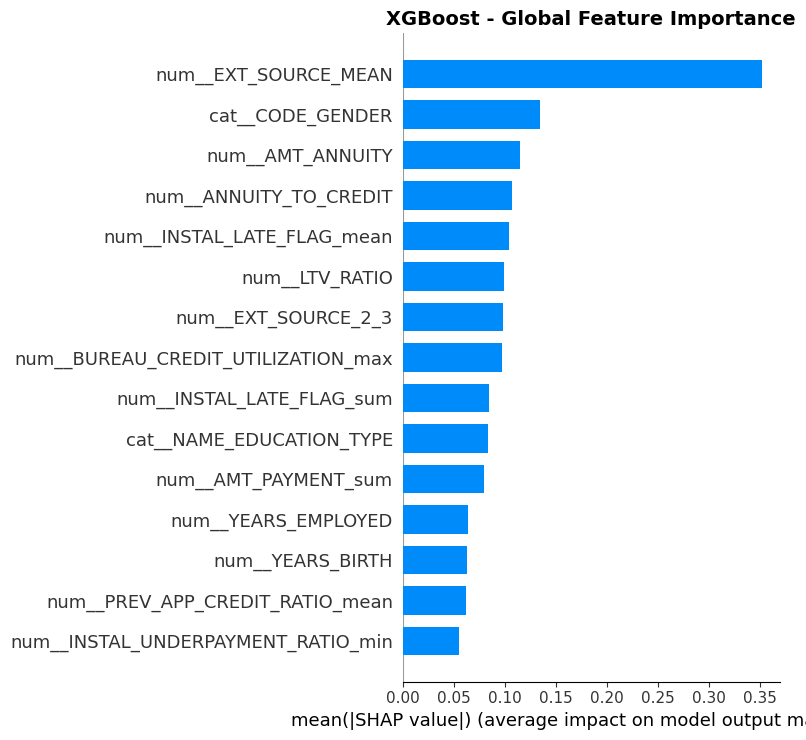

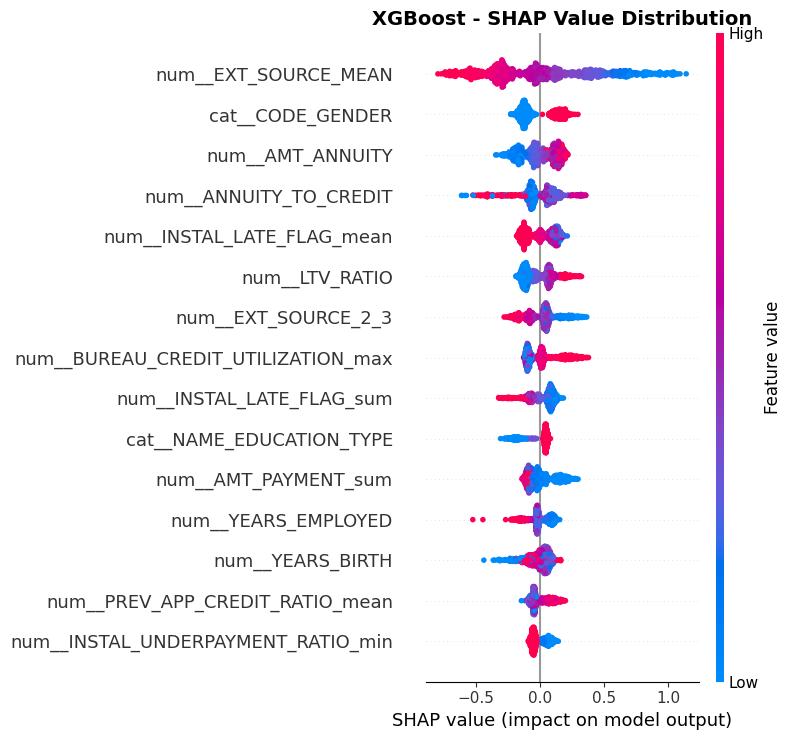

In [17]:
shap_xgb, xgb_feature_names, shap_xgb_top20 = analyze_shap_separate_plots(
    model_xgb_best, X_train170, "XGBoost"
)

In [22]:
shap_xgb_top20[:5]

num__EXT_SOURCE_MEAN          0.352029
cat__CODE_GENDER              0.134321
num__AMT_ANNUITY              0.114739
num__ANNUITY_TO_CREDIT        0.106998
num__INSTAL_LATE_FLAG_mean    0.104263
dtype: float64

**XGBoost top 5 SHAP features** look almost identical to the LightGBM ones: 
        
    - close feature order and plot color patterns (red/blue trends).

XGBoost and LightGBM are showing very consistent signals:
    
    EXT_SOURCE_MEAN dominates (strongest predictor).
    
    Gender matters in the same direction.
    
    Annuity and ratios behave similarly.
    
    Late flag mean shows the same surprising “inverted” effect.

**Top 20 SHAP features comparison LGBM and XGB.**

In [26]:
shap_lgbm_top20

num__EXT_SOURCE_MEAN                  0.343614
cat__CODE_GENDER                      0.146851
num__ANNUITY_TO_CREDIT                0.117619
num__AMT_ANNUITY                      0.107107
num__INSTAL_LATE_FLAG_mean            0.105783
num__LTV_RATIO                        0.103092
num__BUREAU_CREDIT_UTILIZATION_max    0.097949
num__AMT_PAYMENT_sum                  0.087113
num__INSTAL_LATE_FLAG_sum             0.082334
num__EXT_SOURCE_2_3                   0.079023
cat__NAME_EDUCATION_TYPE              0.077774
num__YEARS_EMPLOYED                   0.069464
num__YEARS_BIRTH                      0.064363
cat__NAME_FAMILY_STATUS               0.061659
num__AMT_GOODS_PRICE                  0.057240
num__EXT_SOURCE_2                     0.057023
num__missingindicator_OWN_CAR_AGE     0.053197
num__PREV_APP_CREDIT_RATIO_mean       0.052966
num__CNT_INSTALMENT_max               0.051306
num__YEARS_ID_PUBLISH                 0.050583
dtype: float64

In [27]:
shap_xgb_top20

num__EXT_SOURCE_MEAN                         0.352029
cat__CODE_GENDER                             0.134321
num__AMT_ANNUITY                             0.114739
num__ANNUITY_TO_CREDIT                       0.106998
num__INSTAL_LATE_FLAG_mean                   0.104263
num__LTV_RATIO                               0.099340
num__EXT_SOURCE_2_3                          0.098216
num__BUREAU_CREDIT_UTILIZATION_max           0.097124
num__INSTAL_LATE_FLAG_sum                    0.084559
cat__NAME_EDUCATION_TYPE                     0.083590
num__AMT_PAYMENT_sum                         0.079431
num__YEARS_EMPLOYED                          0.064309
num__YEARS_BIRTH                             0.063171
num__PREV_APP_CREDIT_RATIO_mean              0.062224
num__INSTAL_UNDERPAYMENT_RATIO_min           0.055522
cat__NAME_FAMILY_STATUS                      0.055030
num__YEARS_ID_PUBLISH                        0.050435
num__POS_INSTALMENTS_COMPLETED_RATIO_mean    0.047740
num__CNT_INSTALMENT_max     

**Top 17 most important features for both models**

**Core Features**

    1. num__EXT_SOURCE_MEAN

        Average of external credit bureau scores (EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3).

            Proxy for creditworthiness: higher = better external evaluation, lower = riskier.

    2. cat__CODE_GENDER

        Gender of the client (Male / Female).

            Encoded with OrdinalEncoder (0 = Female, 1 = Male).
    
    3. num__AMT_ANNUITY
    
        Loan annuity = fixed periodic payment (monthly installment).
    
            Larger annuity = higher repayment burden.
    
    4. num__ANNUITY_TO_CREDIT
    
        Ratio of annuity to credit amount.
    
            Measures how heavy monthly repayments are relative to loan size.
    
    5. num__INSTAL_LATE_FLAG_mean
    
        Average fraction of installments paid late (from installment payment history).
    
            Closer to 1 = many late payments; closer to 0 = mostly on time.

    6. num__LTV_RATIO
    
        Loan-to-value ratio = (loan amount / goods price).
        
            Higher = borrower financed a large proportion of the asset with credit (riskier).
    
**Credit Behavior Features**
    
    7. num__BUREAU_CREDIT_UTILIZATION_max
    
        Maximum credit utilization observed in bureau records.
    
            Utilization = credit balance / credit limit. High values = heavy reliance on credit.
    
    8. num__INSTAL_LATE_FLAG_sum
    
        Total number of late installments (not normalized like the mean).
    
            Reflects absolute history of missed/late payments.
    
    9. num__EXT_SOURCE_2_3

        Feature engineering: interaction or aggregation between EXT_SOURCE_2 and EXT_SOURCE_3.
    
            Helps capture nonlinear signal from external scores.
    
    10. cat__NAME_EDUCATION_TYPE
    
        Client’s highest education level. Categories like Secondary, Higher, Academic degree.
    
            Encoded with OrdinalEncoder.
    
    11. num__AMT_PAYMENT_sum
    
        Total sum of payments made (from installment/payment history).
    
            Proxy for repayment activity and capacity.

**Demographic / Employment Features**
    
    12. num__YEARS_EMPLOYED
    
        Years employed at current job (converted from DAYS_EMPLOYED).
    
            Longer = more stable employment, usually lower risk.
    
    13. num__YEARS_BIRTH
    
        Client’s age (converted from DAYS_BIRTH).
    
            Younger borrowers often higher risk, older sometimes more stable.
    
    14. num__PREV_APP_CREDIT_RATIO_mean
    
        From previous loan applications: average ratio of credit amount to requested amount.
    
            Reflects past borrowing patterns and whether requests were fulfilled.

    15. cat__NAME_FAMILY_STATUS
    
        Family/marital status (Single, Married, Civil marriage, etc.).
    
            Encoded with OrdinalEncoder. Family support can correlate with repayment risk.
    
    16. num__YEARS_ID_PUBLISH
    
        Years since ID was issued (converted from DAYS_ID_PUBLISH).
    
            Very recent IDs sometimes correlate with instability or fraud risk.
    
    17. num__CNT_INSTALMENT_max
    
        Maximum number of installments for any loan (loan length).
    
            Longer loans = different repayment patterns; can influence affordability.

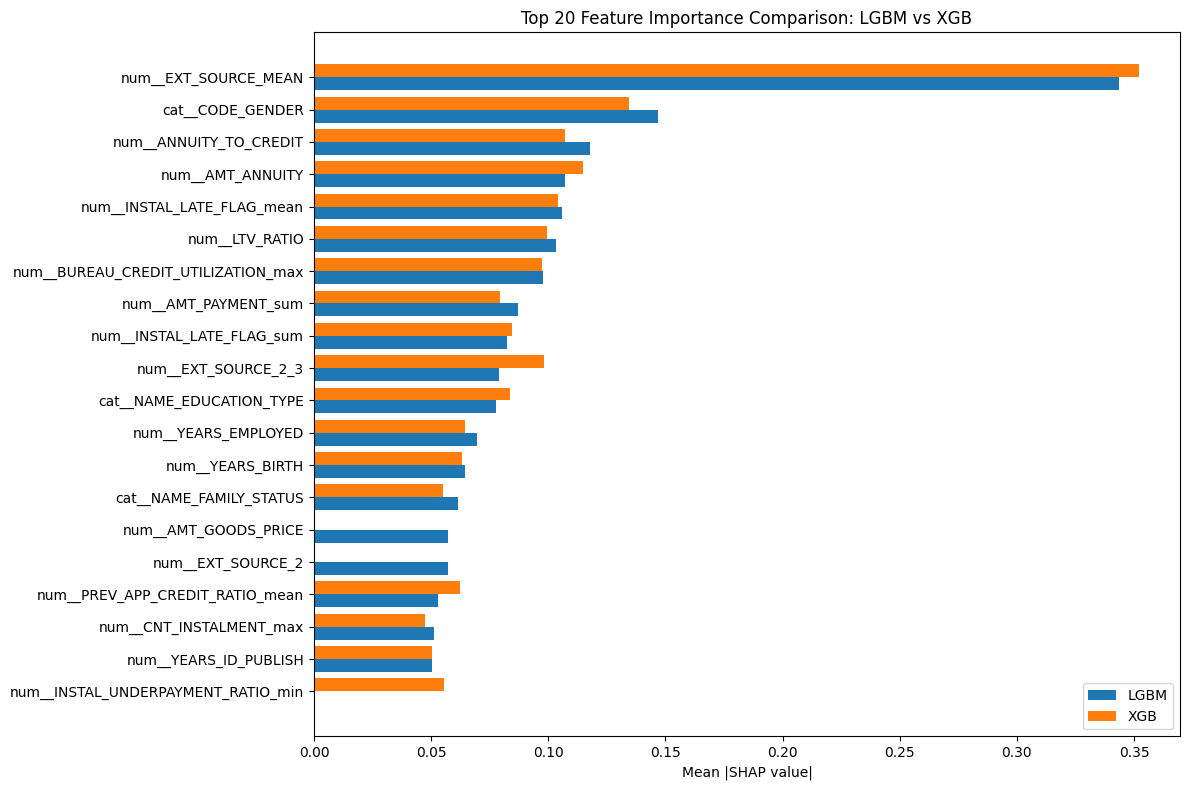

In [18]:
plot_shap_top20_comparison(shap_lgbm_top20, shap_xgb_top20)

**The top 13 most important features are nearly identical** between the LightGBM and XGBoost models, differing only in their specific importance weights: 

This core set of features, from EXT_SOURCE_MEAN to YEARS_BIRTH, represents the key drivers of model prediction for both algorithms.

Beyond the top 13, the two models diverge slightly in their feature rankings. However, within the top 20 features, only three unique features are identified by one model and not the other, reinforcing the strong alignment in how both models interpret the most influential variables.

**SHAP Dependence Plots for Top 3 LGBM features**

    1. num__EXT_SOURCE_MEAN - num__YEARS_BIRTH - younger vs older clients with same external score.
    
    2. cat__CODE_GENDER - num__EXT_SOURCE_MEAN - do males/females with the same external score differ in risk effect.
    
    3. num__AMT_ANNUITY - num__YEARS_BIRTH - whether older client reduce the negative impact of high annuities.


SHAP Dependence Plot for: num__EXT_SOURCE_MEAN (interaction: num__YEARS_BIRTH)


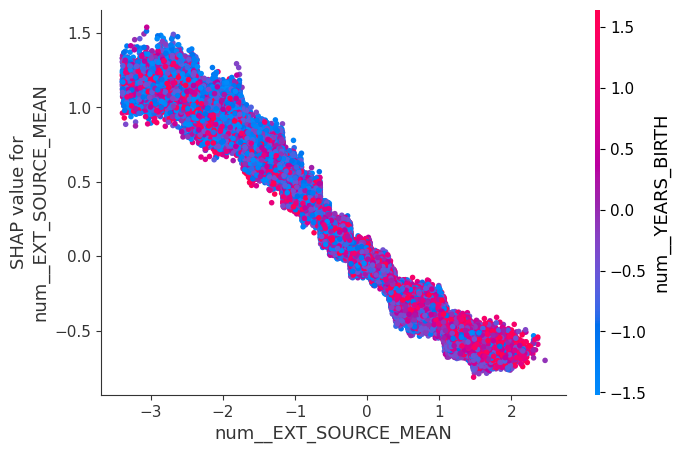


SHAP Dependence Plot for: cat__CODE_GENDER (interaction: num__EXT_SOURCE_MEAN)


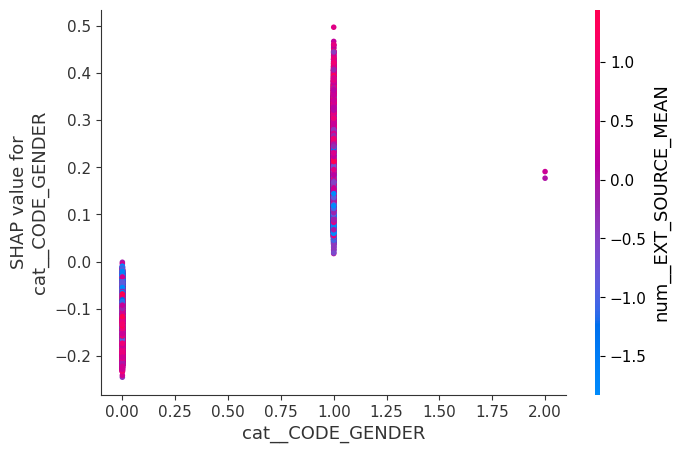


SHAP Dependence Plot for: num__ANNUITY_TO_CREDIT (interaction: num__YEARS_EMPLOYED)


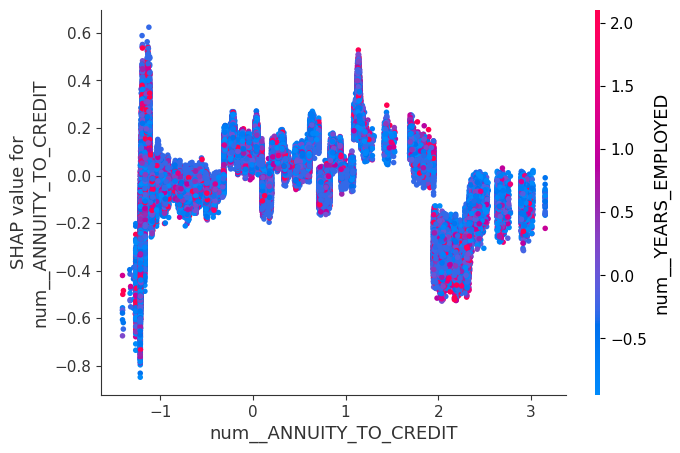

In [26]:
X_sample = preprocessor170.transform(X_train170)

explainer = shap.TreeExplainer(model_lgbm_best.named_steps["classifier"])
shap_values = explainer.shap_values(X_sample)
shap_values_matrix = shap_values[1] if isinstance(shap_values, list) else shap_values
feature_names = preprocessor170.get_feature_names_out()

shap_df = pd.DataFrame(shap_values_matrix, columns=feature_names)
mean_abs_shap = shap_df.abs().mean().sort_values(ascending=False)
top_15_features = mean_abs_shap.head(15)

interaction_map = {
    "num__EXT_SOURCE_MEAN": "num__YEARS_BIRTH",
    "cat__CODE_GENDER": "num__EXT_SOURCE_MEAN",
    "num__ANNUITY_TO_CREDIT": "num__YEARS_EMPLOYED",
}

for feature in shap_lgbm_top20.index[:3]:
    interaction = interaction_map.get(feature, "auto")
    print(f"\nSHAP Dependence Plot for: {feature} (interaction: {interaction})")
    shap.dependence_plot(
        feature,
        shap_values_matrix,
        X_sample,
        feature_names=feature_names,
        interaction_index=interaction,
        show=True,
    )

**Key insights**

**1. num__EXT_SOURCE_MEAN × num__YEARS_BIRTH**

    Trend: Almost linear.
    
        Higher external scores - negative SHAP - lower predicted default.
    
        Lower external scores - positive SHAP - higher predicted default.

    Color (age) effect:
    
        Older clients (red) with high scores tend to have even lower predicted risk.
    
        Younger clients (blue) with low scores tend to have higher predicted risk.

    Interpretation: External creditworthiness is protective across ages, but older clients benefit slightly more from high scores.

**2. cat__CODE_GENDER × num__EXT_SOURCE_MEAN**

    Trend:
    
        Female (code 0) - mostly negative SHAP - lower predicted default.
        
        Male (code 1) - mostly positive SHAP - higher predicted default.
    
    Color (external score) effect:
    
    Red = higher external score, Blue = lower.
        
        Females with higher external scores (red) have lowest predicted risk.
        
        Males with higher scores (red) have highest predicted risk.
    
    Interpretation: Gender effect interacts with credit score.

**3. num__ANNUITY_TO_CREDIT × num__YEARS_EMPLOYED**
        
        Trend: Very mixed/non-linear.
        
            For ratios < –1, SHAP values spread between –0.8 and +0.6 → some clients are predicted safer, others riskier, depending on employment.

            For ratios ~ –1 to 2, SHAP values cluster near zero, but with a slight positive tilt → ratio here doesn’t strongly increase default risk.
            
            For ratios above 2–3, SHAP values lean negative → higher ratio surprisingly reduces predicted risk in some regions
        
        Color (years employed) effect:
        
        Red = longer employment, Blue = shorter employment.
        
            Across all ratio ranges, red and blue points are spread almost equally → employment length does not dominate this feature’s SHAP effect
        

**Summary Takeaways:**

    EXT_SOURCE_MEAN - linear protective effect, amplified by age.
    
    CODE_GENDER - interacts with external score; gender matters most when combined with creditworthiness.
    
    ANNUITY_TO_CREDIT - very high ratios (2–3) are often associated with lower predicted risk

## 7. Ensembling

### A. Ensemble with calibration

**The calibration plots** for both LGBM and XGBoost showed poor alignment between predicted probabilities and actual outcomes. This means the raw model probabilities tend to be over- or under-confident, even though the ranking (AUC) may be good.

To check models improvement, we will combine LGBM and XGB in an ensemble and apply calibration techniques.

In [34]:
categorical_cols = X_train170.select_dtypes(exclude=[np.number]).columns
numeric_cols = X_train170.select_dtypes(include=[np.number]).columns

preprocessor_clf = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ]
)

best_lgbm = Pipeline(
    steps=[
        ("preprocessor", preprocessor_clf),
        ("model", LGBMClassifier(**lgbm_best_params)),
    ]
)

best_xgb = Pipeline(
    steps=[
        ("preprocessor", preprocessor_clf),
        ("model", XGBClassifier(**xgb_best_params, use_label_encoder=False)),
    ]
)

In [37]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

calibrated_lgbm = CalibratedClassifierCV(best_lgbm, cv=3, method="isotonic")
calibrated_xgb = CalibratedClassifierCV(best_xgb, cv=3, method="isotonic")

calibrated_lgbm.fit(X_train170, y_train)
calibrated_xgb.fit(X_train170, y_train)


for name, model in [
    ("LGBM", calibrated_lgbm),
    ("XGB", calibrated_xgb),
]:
    preds = model.predict(X_train170)
    probs = model.predict_proba(X_train170)[:, 1]
    print(f"\n{name}")
    print(classification_report(y_train, preds))
    print(f"ROC-AUC: {roc_auc_score(y_train, probs):.4f}")
    print(f"F1: {f1_score(y_train, preds):.4f}")
    print(f"PR-AUC: {average_precision_score(y_train, probs):.4f}")

voting_ensemble = VotingClassifier(
    estimators=[
        ("lgbm", calibrated_lgbm),
        ("xgb", calibrated_xgb),
    ],
    voting="soft",
)

voting_ensemble.fit(X_train170, y_train)

preds = voting_ensemble.predict(X_train170)
probs = voting_ensemble.predict_proba(X_train170)[:, 1]

print("\n=== Calibrated Ensemble (LGBM + XGB) ===")
print(classification_report(y_train, preds))
print(f"ROC-AUC: {roc_auc_score(y_train, probs):.4f}")
print(f"F1: {f1_score(y_train, preds):.4f}")
print(f"PR-AUC: {average_precision_score(y_train, probs):.4f}")


LGBM
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    226148
           1       0.70      0.05      0.09     19860

    accuracy                           0.92    246008
   macro avg       0.81      0.52      0.52    246008
weighted avg       0.90      0.92      0.89    246008

ROC-AUC: 0.8588
F1: 0.0866
PR-AUC: 0.3679

XGB
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    226148
           1       0.66      0.04      0.08     19860

    accuracy                           0.92    246008
   macro avg       0.79      0.52      0.52    246008
weighted avg       0.90      0.92      0.89    246008

ROC-AUC: 0.8305
F1: 0.0769
PR-AUC: 0.3317

=== Calibrated Ensemble (LGBM + XGB) ===
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    226148
           1       0.69      0.04      0.08     19860

    accuracy                           0.92  

**Key takeaways:**

    Calibration improves recall (more defaults detected), but at the cost of precision and ROC-AUC.
    
    F1 is very low because the dataset is heavily imbalanced (only ~8% defaults).
    
    PR-AUC increased after calibration.

The metrics clearly show the trade-off between ranking quality (ROC-AUC) and probability reliability (PR/F1).


**Primary goal is ROC-AUC** (good ranking of risk, not exact probabilities),

**so we will use ensemble without calibration and focus on ranking metrics.**


For real-world decision-making - we would consider calibration and threshold tuning to improve recall or F1 for defaults.

### B. Ensemble without calibration

**Weighted voting = LGBM - 0.7, XGB - 0.3**

In [13]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

model_lgbm_best = Pipeline(
    [
        ("preprocessor", preprocessor170),
        ("classifier", LGBMClassifier(**lgbm_best_params)),
    ]
)

model_xgb_best = Pipeline(
    [
        ("preprocessor", preprocessor170),
        ("classifier", XGBClassifier(**xgb_best_params)),
    ]
)


def evaluate_model(name, model, X, y, cv):
    start = time.time()
    y_probs = cross_val_predict(model, X, y, cv=cv, method="predict_proba")[:, 1]
    y_pred = (y_probs >= 0.5).astype(int)
    elapsed = time.time() - start

    print(f"\n=== {name} ===")
    print(classification_report(y, y_pred))
    print(f"ROC-AUC: {roc_auc_score(y, y_probs):.4f}")
    print(f"F1: {f1_score(y, y_pred):.4f}")
    print(f"PR-AUC: {average_precision_score(y, y_probs):.4f}")
    print(f"Time: {elapsed:.1f}s")


evaluate_model("LGBM (baseline)", model_lgbm_best, X_train170, y_train, cv)

voting_weighted = VotingClassifier(
    estimators=[("lgbm", model_lgbm_best), ("xgb", model_xgb_best)],
    voting="soft",
    weights=[0.7, 0.3],  # tune these!
)
evaluate_model("Voting (weighted LGBM> XGB)", voting_weighted, X_train170, y_train, cv)


=== LGBM (baseline) ===
              precision    recall  f1-score   support

           0       0.96      0.75      0.84    226148
           1       0.19      0.68      0.30     19860

    accuracy                           0.75    246008
   macro avg       0.58      0.72      0.57    246008
weighted avg       0.90      0.75      0.80    246008

ROC-AUC: 0.7881
F1: 0.3016
PR-AUC: 0.2784
Time: 328.7s

=== Voting (weighted LGBM> XGB) ===
              precision    recall  f1-score   support

           0       0.96      0.75      0.84    226148
           1       0.19      0.68      0.30     19860

    accuracy                           0.74    246008
   macro avg       0.58      0.72      0.57    246008
weighted avg       0.90      0.74      0.80    246008

ROC-AUC: 0.7887
F1: 0.3013
PR-AUC: 0.2799
Time: 674.1s


**Main Metric – ROC-AUC:**

    The ensemble model slightly outperforms the baseline (0.7887 vs. 0.7881), indicating marginally better overall discrimination between classes.

**Class 1 (Minority Class):**

    Both models struggle with precision (0.19) but achieve decent recall (0.68), suggesting they catch most positives but with many false alarms.

**F1 Score:**

    Nearly identical, showing no meaningful gain in balance between precision and recall.

**PR-AUC:**

    Slight improvement in the ensemble, which is encouraging for imbalanced classification.

**Trade-off:**

    Ensemble takes more than twice the time to run, with only minimal performance gain.

### C. Ensemble performance on Test set. Confusion matrix 

In [26]:
X_test170 = X_test[selected]


=== Weighted Voting Ensemble on X_test ===
              precision    recall  f1-score   support

           0       0.97      0.75      0.84     56538
           1       0.19      0.70      0.30      4965

    accuracy                           0.74     61503
   macro avg       0.58      0.72      0.57     61503
weighted avg       0.90      0.74      0.80     61503

ROC-AUC: 0.7914
F1: 0.3033
PR-AUC: 0.2916


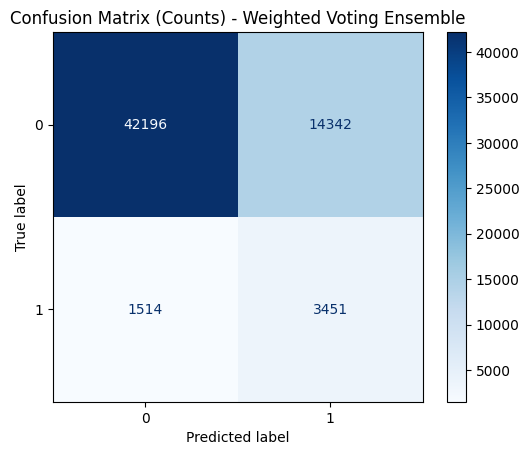

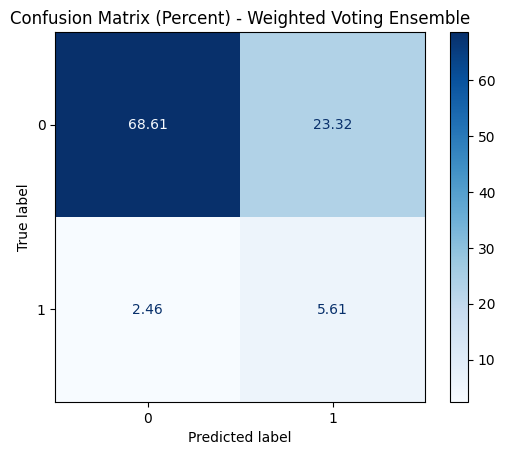

In [14]:
voting_weighted.fit(X_train170, y_train)

y_test_probs = voting_weighted.predict_proba(X_test170)[:, 1]
y_test_pred = (y_test_probs >= 0.5).astype(int)

print("\n=== Weighted Voting Ensemble on X_test ===")
print(classification_report(y_test, y_test_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, y_test_probs):.4f}")
print(f"F1: {f1_score(y_test, y_test_pred):.4f}")
print(f"PR-AUC: {average_precision_score(y_test, y_test_probs):.4f}")

cm_counts = confusion_matrix(y_test, y_test_pred)

cm_percent = confusion_matrix(y_test, y_test_pred, normalize="all") * 100

disp_counts = ConfusionMatrixDisplay(
    confusion_matrix=cm_counts, display_labels=voting_weighted.classes_
)
disp_counts.plot(cmap="Blues")
plt.title("Confusion Matrix (Counts) - Weighted Voting Ensemble")
plt.show()

disp_percent = ConfusionMatrixDisplay(
    confusion_matrix=cm_percent, display_labels=voting_weighted.classes_
)
disp_percent.plot(cmap="Blues", values_format=".2f")
plt.title("Confusion Matrix (Percent) - Weighted Voting Ensemble")
plt.show()

**Weighted ensemble** model showed better result on test set than on train set.
    
    ROC-AUC Train: 0.7887 / Test: 0.7914

        - model generalizes well and is not overfitting.

    F1 Score Train: 0.3013 / Test: 0.3033

        - threshold behavior is stable across datasets.

    PR-AUC Train: 0.2799 → Test: 0.2916

        - slightly higher on test - model performs as expected on unseen data.

**The weighted voting ensemble is stable and well-generalized**. There’s no sign of overfitting (train vs test metrics are nearly identical). The model achieves solid ranking power (ROC-AUC ~0.79) and reasonable performance on imbalanced data (PR-AUC ~0.29).

**Confusion matrix:**

    True Negatives (68.61%) - Correctly predicting non-default clients.
    
    False Positives (23.32%) - Predicting default where there isn’t one - costly for business if it rejects good clients.
    
    False Negatives (2.46%) - Default cases predicted as safe - this is the most dangerous error in credit risk.
    
    True Positives (5.61%) - Defaults correctly detected.

So the model is catching 70% of defaults (recall) but at the cost of flagging 23% of safe clients incorrectly.

**Business perspective:**

    Strengths:
    
        High recall (70%) means the bank identifies most risky clients.
        
        ROC-AUC ~0.79 shows the probability scores are meaningful and can be threshold-tuned.
        
    Weaknesses:
        
        Precision is very low - most clients predicted "risky" are actually safe.
        
        This leads to high false positives (rejected good clients).

**Precision recall plot**

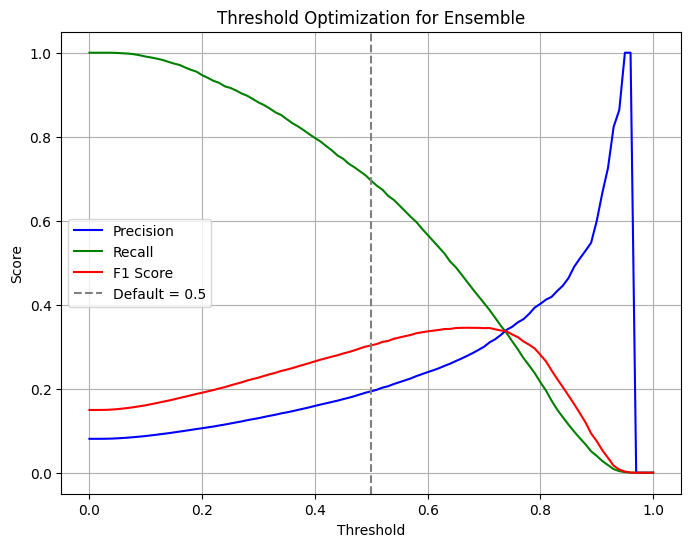

Best F1: 0.345 at threshold=0.67
Max Recall: 1.000 at threshold=0.00
Max Precision: 1.000 at threshold=0.95


In [40]:
y_test_probs = voting_weighted.predict_proba(X_test170)[:, 1]
y_test_pred = (y_test_probs >= 0.5).astype(int)

plot_threshold_optimization(y_test, y_test_probs)

**Key insights**

    Our main metric is **ROC-AUC** (the competition metric) so we don't need to do calibration (lower ROC_AUC) and threshold optimization.

**In real-world credit risk modeling**

    we would need to perform calibration, error analysis, threshold optimization.

    In credit risk, most banks lean toward high recall (catch risky clients):

        - A false negative (FN) - giving a loan to a defaulter - huge financial loss.
        
        - A false positive (FP) - rejecting a safe client - lost profit, but not catastrophic.

        Thresholds are tuned to maximize recall at an acceptable precision level (e.g., recall ≥ 0.8 while keeping precision ≥ 0.3).

    In our case threshol < 0.4 would give recall > 0.8, but precision would drop > 0.18.

**Submitting ensemble result to Kaggle**

In [16]:
X_test170 = test_df_enriched[selected]
test_ids = test_df_enriched["SK_ID_CURR"]

voting_weighted.fit(X_train170, y_train)

y_test_probs = voting_weighted.predict_proba(X_test170)[:, 1]

submission = pd.DataFrame({"SK_ID_CURR": test_ids, "TARGET": y_test_probs})
submission.to_csv("submission_voting_170_cv5.csv", index=False)

print("Submission file saved as submission_voting_170_cv5.csv")

Submission file saved as submission_voting_170_cv5.csv


**Kaggle result 0.7857** (single LGBM was 0.78515, XGB 0,78323)

**Saving the model**

In [41]:
import joblib

joblib.dump(voting_weighted, "voting_weighted_ensemble.joblib")

# loaded_ensemble = joblib.load("voting_weighted_ensemble.joblib")

['voting_weighted_ensemble.joblib']

## 8. Deploying the model

**Pipeline Serialization**

Saved files for deployment:

    - lgbm_importances.csv - sorted features by LGBM model importance (we will use top170)
    
    - categorical.json - categorical type features in top170
    
    - numerical.json - numerical type features in top170
    
    - voting_weighted_ensemble.joblib - ensemlbe model weighted (LGBM 0.7, XGB 0.3) and preprocessing pipeline

**Inference Process**

    - Accept raw tables (customer info, installments, bureau, POS, previous apps, etc.).

    - Run feature engineering (utils_modeling functions).
    
    - Merge and select top 170 features based on saved importance list.
    
    - Apply the trained voting ensemble.
    
    - Output predicted probability and labels.

**Deployment Environment**

    - Docker container, Google Cloud.

**Production Considerations**

   - Monitoring for model drift and periodic retraining would ensure continued predictive performance.

## 9. Summary

**Key Steps & Findings:**

**Data & Preprocessing:**

    Merged main and auxiliary datasets (bureau, previous loans, credit card balances, etc.)
    
    Preprocessed missing values, handled anomalies, converted DAYS → YEARS, and engineered domain-informed features

**Model Comparison:**

    Evaluated six models: Logistic Regression, Random Forest, HistGB, CatBoost, LightGBM, XGBoost
    
    Best models: LightGBM (fast, strong F1) and XGBoost (slightly higher F1, solid ROC-AUC)

    CatBoost performed similarly but was too slow; Random Forest and Logistic Regression underperformed

**Feature Selection & Hyperparameter Tuning:**

    Selected top 170 features based on LightGBM importance
    
    Optuna tuning improved LightGBM ROC-AUC to 0.7881 and XGBoost to 0.7863, with reduced training time

**Ensemble & Evaluation:**

    Weighted ensemble slightly improved ROC-AUC to 0.7914 on test data
    
    High recall (~70%) achieved at the cost of precision (~23%), consistent with credit risk priorities
    
    PR-AUC and F1 reflect imbalanced dataset; calibration not applied to preserve ROC-AUC

**Feature Insights:**

    Key predictors: EXT_SOURCE_1/2/3 - mean, GENDER, YEARS_BIRTH, YEARS_EMPLOYED, OCCUPATION_TYPE, ORGANIZATION_TYPE
    
    SHAP analysis confirms consistent feature importance and directional effects across LightGBM and XGBoost.

**Conclusion:**

    The modeling pipeline demonstrates strong predictive performance (ROC-AUC ~0.79) with stable generalization on test data.
    
    Ensemble is suitable for deployment.

The approach balances predictive power, speed, and interpretability, highlighting the value of feature engineering and careful model selection.

**Suggestions fore improvement:**
    
    Explore additional feature engineering techniques to uncover hidden patterns and enrich the dataset.
    
    Revise the feature selection strategy (from additional datasets): instead of relying on LightGBM with ROC-AUC, consider using all available features and allowing the model to learn which ones are most predictive.
    
    Expand the ensemble by incorporating complementary models such as logistic regression to improve generalization and stability.
    
    Adopt more robust feature selection methods, including Boruta or Optuna-based optimization, to enhance model interpretability and performance.
    
    Conduct thorough error analysis to identify specific segments or cases where the model underperforms, enabling targeted improvements.
    
    Optimize the precision-recall trade-off for real-world deployment by applying techniques like probability calibration and threshold tuning, tailored to client-specific needs.
